In [610]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
import itertools
import scipy.stats
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from scipy.linalg import pinv

#g_cluster_range = [3,5,7,8,9,10,12,14,16,17,20,24,26,30,32,34,36,38,40]
g_cluster_range = [3,5,7,8,9,10,12,14,16,17]

#g_cluster_range = [7,14,20,30,32,34,38,40]

def RP_analysis(X):
	arr = []
	for i in range(1,X.shape[1]):
		rp = GaussianRandomProjection(n_components=i)
		X_rp = rp.fit(X)
		p = pinv(X_rp.components_)
		w = X_rp.components_
		reconstructed = ((p@w)@(X.T)).T 
		arr.append(mean_squared_error(X,reconstructed))

	arr = np.array(arr)
	plt.plot(np.arange(1,X.shape[1]),arr)
	plt.xlabel('Number of Components')
	plt.ylabel('Reconstruction Error')
	plt.grid()
	plt.show()

def K_Means_inertia_analysis(X):
	cluster_range = g_cluster_range # [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
	inertia_arr = []
	for num_cluster in cluster_range:
		clusterer = KMeans(n_clusters=num_cluster, random_state=10)
		cluster_labels = clusterer.fit(X)
		inertia_arr.append(clusterer.inertia_)
	inertia_arr = np.array(inertia_arr)
	plt.plot(cluster_range,inertia_arr)
	plt.xlabel('Number of Clusters')
	plt.ylabel('Inertia')
	plt.title('Choosing Best k with Inertia')
	plt.show()

def kurtosis_analysis(X):
	arr = []
	for i in range(1,X.shape[1]):
		dim_red = FastICA(n_components = i).fit_transform(X)
		kurt = scipy.stats.kurtosis(dim_red)
		arr.append(np.mean(kurt))
	arr = np.array(arr)
	plt.plot(np.arange(1,X.shape[1]),arr)
	plt.xlabel('Number of Components')
	plt.ylabel('Kurtosis Value')
	plt.grid()
	plt.show()


def K_Means_silhouette_analysis(X,y):
	cluster_range = g_cluster_range # [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
	for num_cluster in cluster_range:
	    figure_to_show, (ax1, ax2) = plt.subplots(1, 2)
	    figure_to_show.set_size_inches(30, 18)
	   
	    ax1.set_xlim([-0.1, 1])
	    ax1.set_ylim([0, len(X) + (num_cluster + 1) * 10])

	    clusterer = KMeans(n_clusters=num_cluster, random_state=10)
	    cluster_labels = clusterer.fit_predict(X)

	    silhouette_avg = silhouette_score(X, cluster_labels)
	    print("For n_clusters = ", num_cluster,
	          "The average silhouette_score is :", silhouette_avg)
	    sample_silhouette_values = silhouette_samples(X, cluster_labels)

	    y_lower = 5
	    for i in range(num_cluster):
	        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

	        ith_cluster_silhouette_values.sort()

	        size_cluster_i = ith_cluster_silhouette_values.shape[0]
	        y_upper = y_lower + size_cluster_i

	        color = cm.nipy_spectral(float(i) / num_cluster)
	        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

	        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

	        y_lower = y_upper + 50 

	    ax1.set_title("The silhouette plot for the various clusters.")
	    ax1.set_xlabel("The silhouette coefficient values")
	    ax1.set_ylabel("Cluster label")

	    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

	    ax1.set_yticks([])  
	    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

	    colors = cm.nipy_spectral(cluster_labels.astype(float) / num_cluster)
	    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
	                c=colors, edgecolor='k')

	    centers = clusterer.cluster_centers_

	    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

	    for i, c in enumerate(centers):
	        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

	    ax2.set_title("The visualization of the clustered data.")
	    ax2.set_xlabel("Feature space for the 1st feature")
	    ax2.set_ylabel("Feature space for the 2nd feature")

	    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with num_cluster = %d" % num_cluster),fontsize=14, fontweight='bold')
	plt.show()

def K_Means_Results(best_n,X,y):
	kmeans = KMeans(n_clusters=best_n, random_state=3169)
	kmeans.fit(X)
	print('K-Means Inertia: ', kmeans.inertia_)
	silh_result = silhouette_score(X, kmeans.labels_)
	print('K-Means Silhouette score: ', silh_result)
	AMI = adjusted_mutual_info_score(y, kmeans.labels_)
	print('K-Means Adjusted Mutual Information (AMI) score: ', AMI)
	print()
	return kmeans.fit_transform(X)

def gmm_analysis(X,y):
	lowest_bic = np.infty
	bic = []
	n_components_range = range(1, 25)
	cv_types = ['spherical', 'tied', 'diag', 'full']
	for cv_type in cv_types:
	    for n_components in n_components_range:
	        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
	        gmm.fit(X)
	        bic.append(gmm.bic(X))
	        if bic[-1] < lowest_bic:
	            lowest_bic = bic[-1]
	            best_gmm = gmm

	bic = np.array(bic)
	color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue','darkorange'])
	clf = best_gmm
	bars = []
	plt.figure(figsize=(8, 6))
	spl = plt.subplot(2, 1, 1)

	for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
	    xpos = np.array(n_components_range) + .2 * (i - 2)
	    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))
	
	plt.xticks(n_components_range)
	plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
	plt.title('BIC score per model')
	xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
	best_num = np.mod(bic.argmin(), len(n_components_range)) + 1
	plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
	spl.set_xlabel('Number of components')
	spl.legend([b[0] for b in bars], cv_types)

	
	splot = plt.subplot(2, 1, 2)
	Y_ = clf.predict(X)
	
	for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,color_iter)):
	    v, w = linalg.eigh(cov)
	    if not np.any(Y_ == i):
	        continue
	    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

	    angle = np.arctan2(w[0][1], w[0][0])
	    angle = 180. * angle / np.pi 
	    v = 2. * np.sqrt(2.) * np.sqrt(v)
	    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
	    ell.set_clip_box(splot.bbox)
	    ell.set_alpha(.5)
	    splot.add_artist(ell)
	
	plt.xticks(())
	plt.yticks(())
	plt.title('Selected GMM: full model,' + str(best_num) + ' components')
	plt.subplots_adjust(hspace=.35, bottom=.02)
	plt.show()
	return best_num

def gmm_results(best_n,X,y):
	gmm_best = GaussianMixture(n_components=best_n, random_state=3169)
	gmm_best.fit(X)
	gmm_labels = gmm_best.predict(X)

	print('GMM BIC: ', gmm_best.bic(X))
	score_gmm = silhouette_score(X, gmm_labels)
	print('GMM Silhouette score: ', score_gmm)
	AMI_gmm = adjusted_mutual_info_score(y, gmm_labels)
	print('GMM Adjusted Mutual Information (AMI) score: ', AMI_gmm)
	print()
	return gmm_best.predict_proba(X)

In [589]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, datasets
import matplotlib.pyplot as plt
import warnings
import os


In [590]:
from sklearn.decomposition import PCA as PCA_sk
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF as NMF_sk
from numpy import linalg as LA
import scipy
from sklearn.random_projection import GaussianRandomProjection
import sys
import time

In [591]:
#df = pd.read_csv("clean_dataset.csv")
df = pd.read_csv("Customer_data.csv")
    

In [592]:
# Run for 2nd dataset#
df['Work_Experience'] = df['Work_Experience'].fillna(df['Work_Experience'].median())
df['Family_Size'] = df['Family_Size'].fillna(df['Family_Size'].median())
df['Ever_Married'].fillna('No',inplace=True)
df['Graduated'].fillna('No',inplace=True)
df.dropna(subset=['Profession'],inplace=True)
df.dropna(subset=['Var_1'],inplace=True)
genders = {'Male':0,'Female':1}
df['Gender'] = df['Gender'].map(genders)

married = {'No':0,'Yes':1}
df['Ever_Married'] = df['Ever_Married'].map(married)

graduate = {'No':0,'Yes':1}
df['Graduated'] = df['Graduated'].map(graduate)

spending_score = {'Low':0,'Average':1,'High':2}
df['Spending_Score'] = df['Spending_Score'].map(spending_score)

var_score = {'Cat_1':1,'Cat_2':2,'Cat_3':3,'Cat_4':4,'Cat_5':5,'Cat_6':6,'Cat_7':7}
df['Var_1'] = df['Var_1'].map(var_score)

rank = {'A':0,'B':1,'C':2,'D':3}
df['Segmentation'] = df['Segmentation'].map(rank)

In [593]:
df = pd.get_dummies(df)
df.head()


ID  Gender  Ever_Married  Age  Graduated  Work_Experience  \
0  462809       0             0   22          0              1.0   
1  462643       1             1   38          1              1.0   
2  466315       1             1   67          1              1.0   
3  461735       0             1   67          1              0.0   
4  462669       1             1   40          1              1.0   

   Spending_Score  Family_Size  Var_1  Segmentation  Profession_Artist  \
0               0          4.0      4             3                  0   
1               1          3.0      4             0                  0   
2               0          1.0      6             1                  0   
3               2          2.0      6             1                  0   
4               2          6.0      6             0                  0   

   Profession_Doctor  Profession_Engineer  Profession_Entertainment  \
0                  0                    0                         0   
1                  0                    1                         0   
2                  0                    1                         0   
3                  0                    0                         0   
4                  0                    0                         1   

   Profession_Executive  Profession_Healthcare  Profession_Homemaker  \
0                     0                      1                     0   
1                     0                      0                     0   
2                     0                      0                     0   
3                     0                      0                     0   
4                     0                      0                     0   

   Profession_Lawyer  Profession_Marketing  
0                  0                     0  
1                  0                     0  
2                  0                     0  
3                  1                     0  
4                  0                     0

In [594]:
X_encoded = df[['Gender','Ever_Married','Age','Graduated','Work_Experience','Spending_Score','Family_Size','Var_1','Profession_Artist','Profession_Doctor','Profession_Engineer','Profession_Entertainment','Profession_Executive','Profession_Healthcare','Profession_Homemaker','Profession_Lawyer','Profession_Marketing']].copy()
y = df['Segmentation'].copy()

In [595]:
X_encoded = df[['PriorDefault','DriversLicense','Income','Employed','CreditScore','YearsEmployed','Debt','Married','BankCustomer','Gender','Age']].copy()
y = df['Approved'].copy()

KeyError: "['PriorDefault', 'DriversLicense', 'Income', 'Employed', 'CreditScore', 'YearsEmployed', 'Debt', 'Married', 'BankCustomer'] not in index"

In [596]:
x = preprocessing.scale(X_encoded)


In [553]:
print(x)

[[ 0.95465038 -0.91919518 -0.19541334 ...  0.55614559  0.66143783
  -0.05772328]
 [ 0.95465038 -0.91919518 -0.08785188 ...  0.55614559 -1.51185789
   2.29131727]
 [ 0.95465038 -0.91919518 -0.03714433 ...  0.55614559 -1.51185789
  -0.59182625]
 ...
 [-1.04750391  1.08790822 -0.19522126 ... -1.79809033 -1.51185789
  -0.52854391]
 [-1.04750391 -0.91919518 -0.05135781 ...  0.55614559  0.66143783
  -1.14702333]
 [-1.04750391  1.08790822 -0.19541334 ...  0.55614559  0.66143783
   0.29412654]]


For n_clusters =  3 The average silhouette_score is : 0.16551699711023235
For n_clusters =  5 The average silhouette_score is : 0.2232997280017481
For n_clusters =  7 The average silhouette_score is : 0.30779047666584725
For n_clusters =  8 The average silhouette_score is : 0.3422491097076016
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jwadhwa\AppData\Local\Temp\ipykernel_35300\1951647032.py", line 1, in <cell line: 1>
    K_Means_silhouette_analysis(x,y)
  File "C:\Users\jwadhwa\AppData\Local\Temp\ipykernel_35300\2612803586.py", line 81, in K_Means_silhouette_analysis
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 233, in silhouette_samples
    kwds["metric"] = metric
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1717, in pairwise_distances_chunked
    ):
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1889, in pairwise_distances
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\metrics\pair

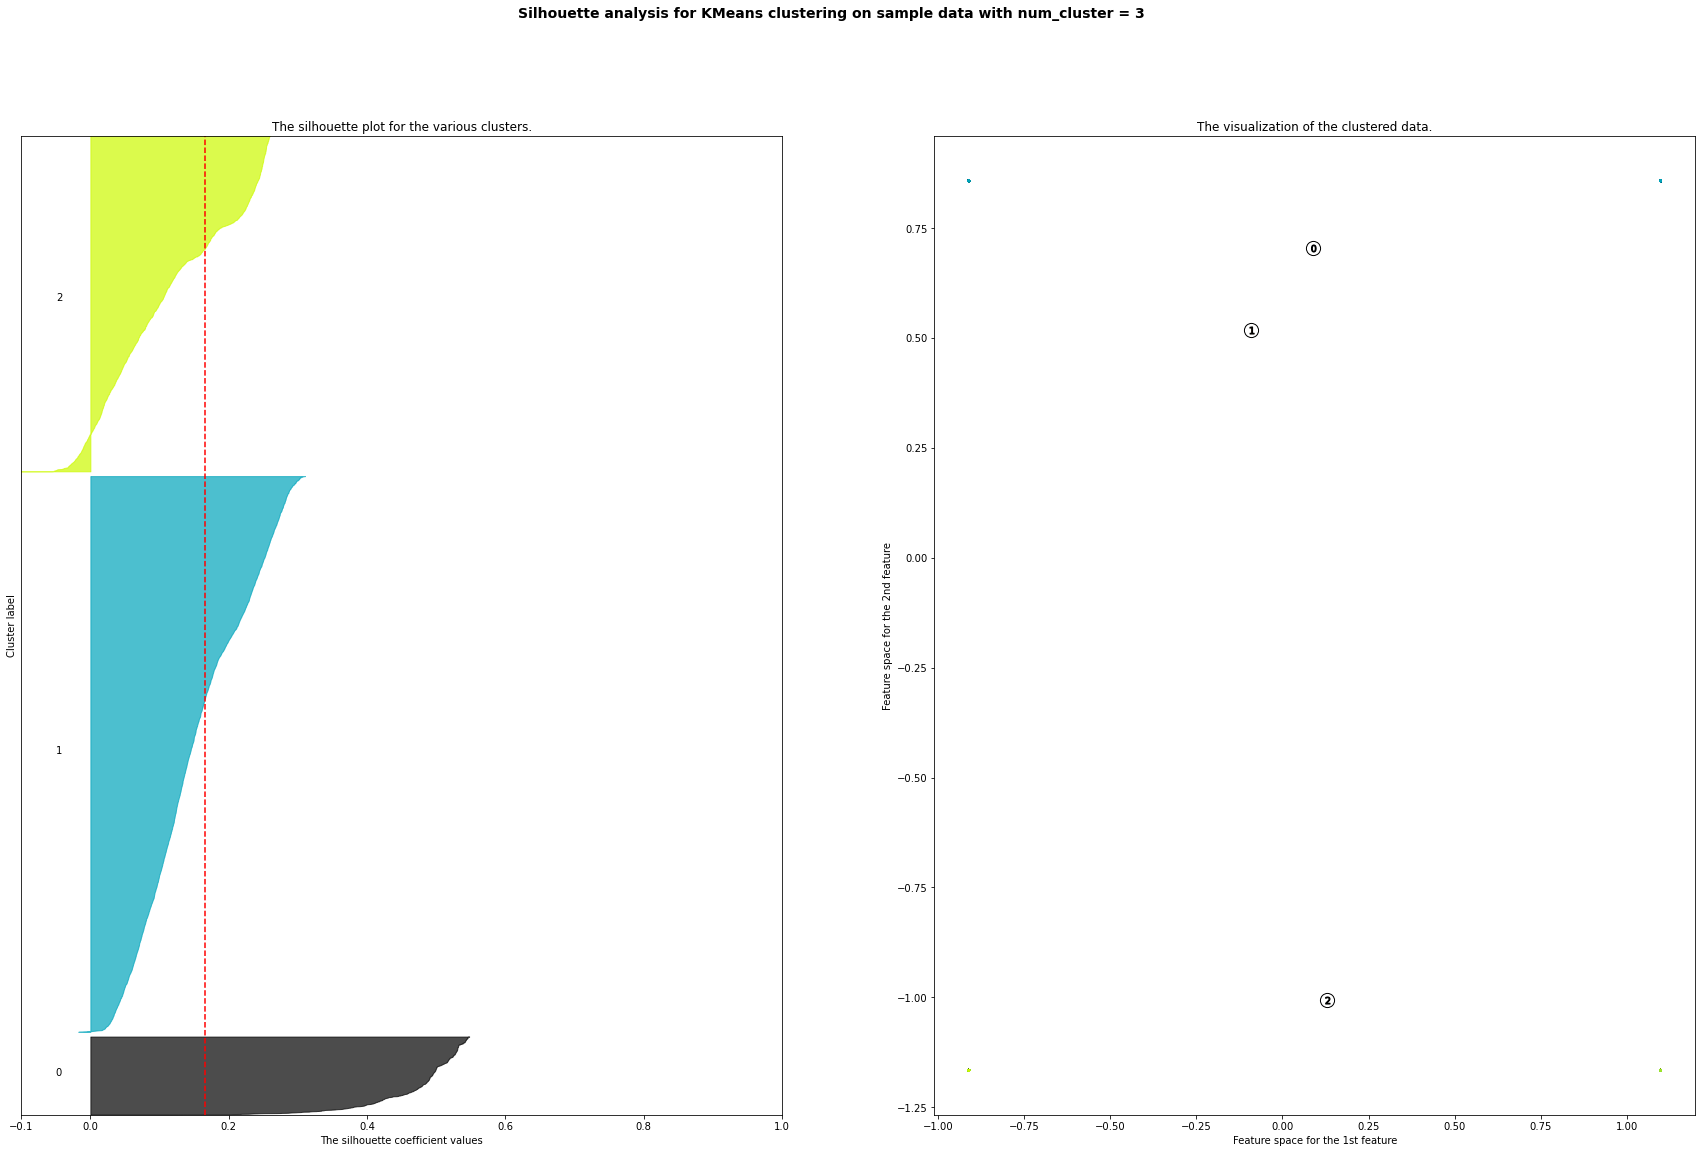

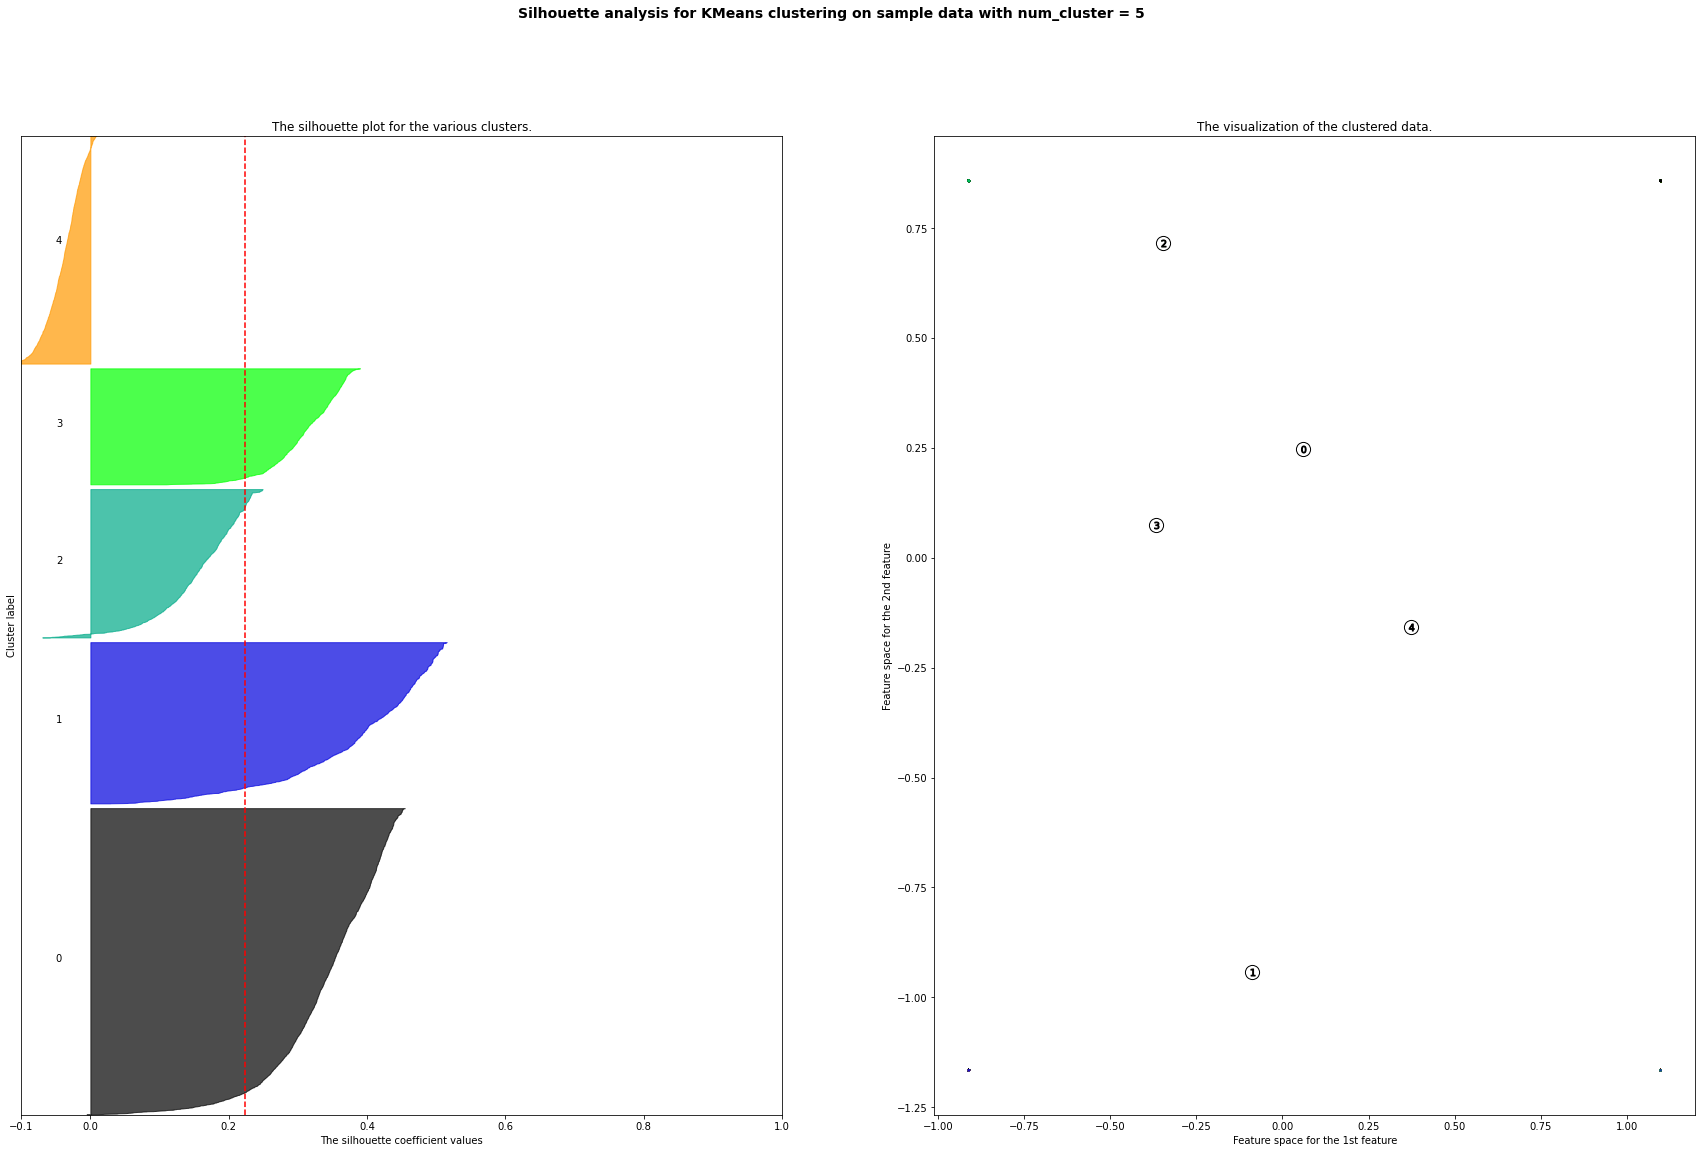

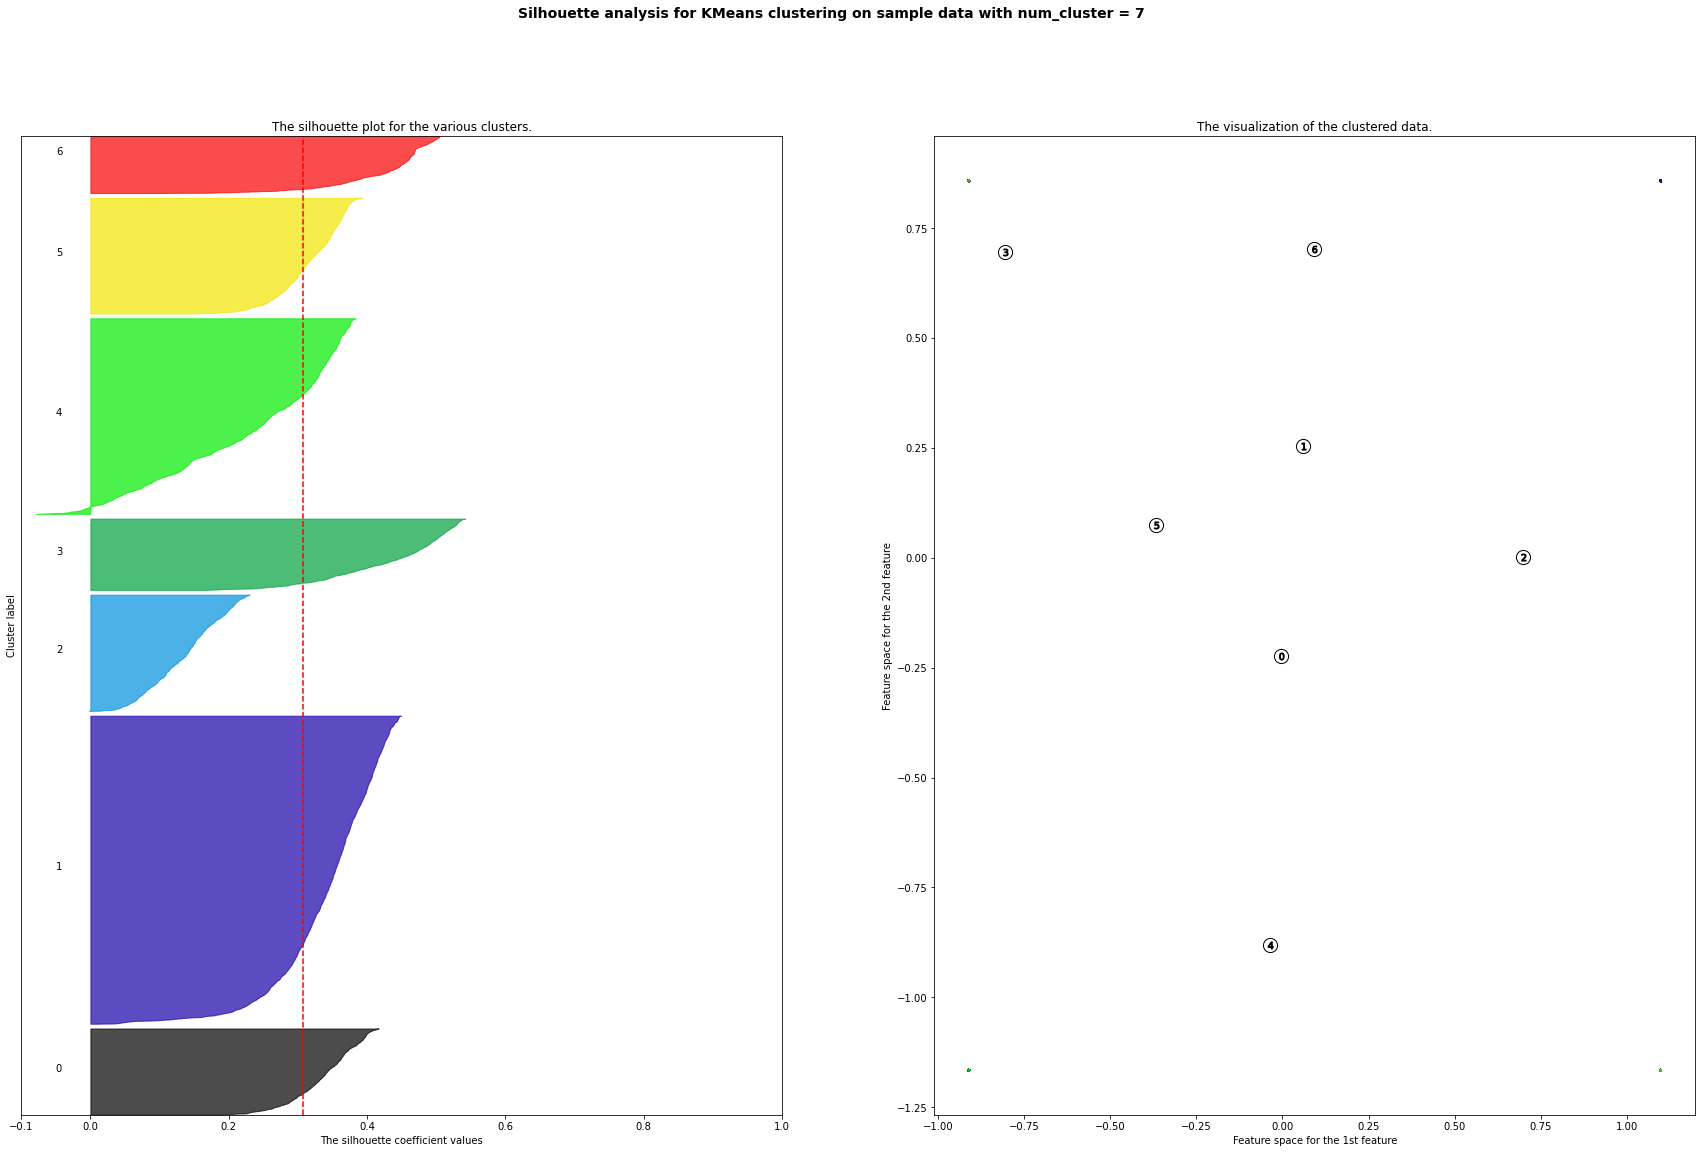

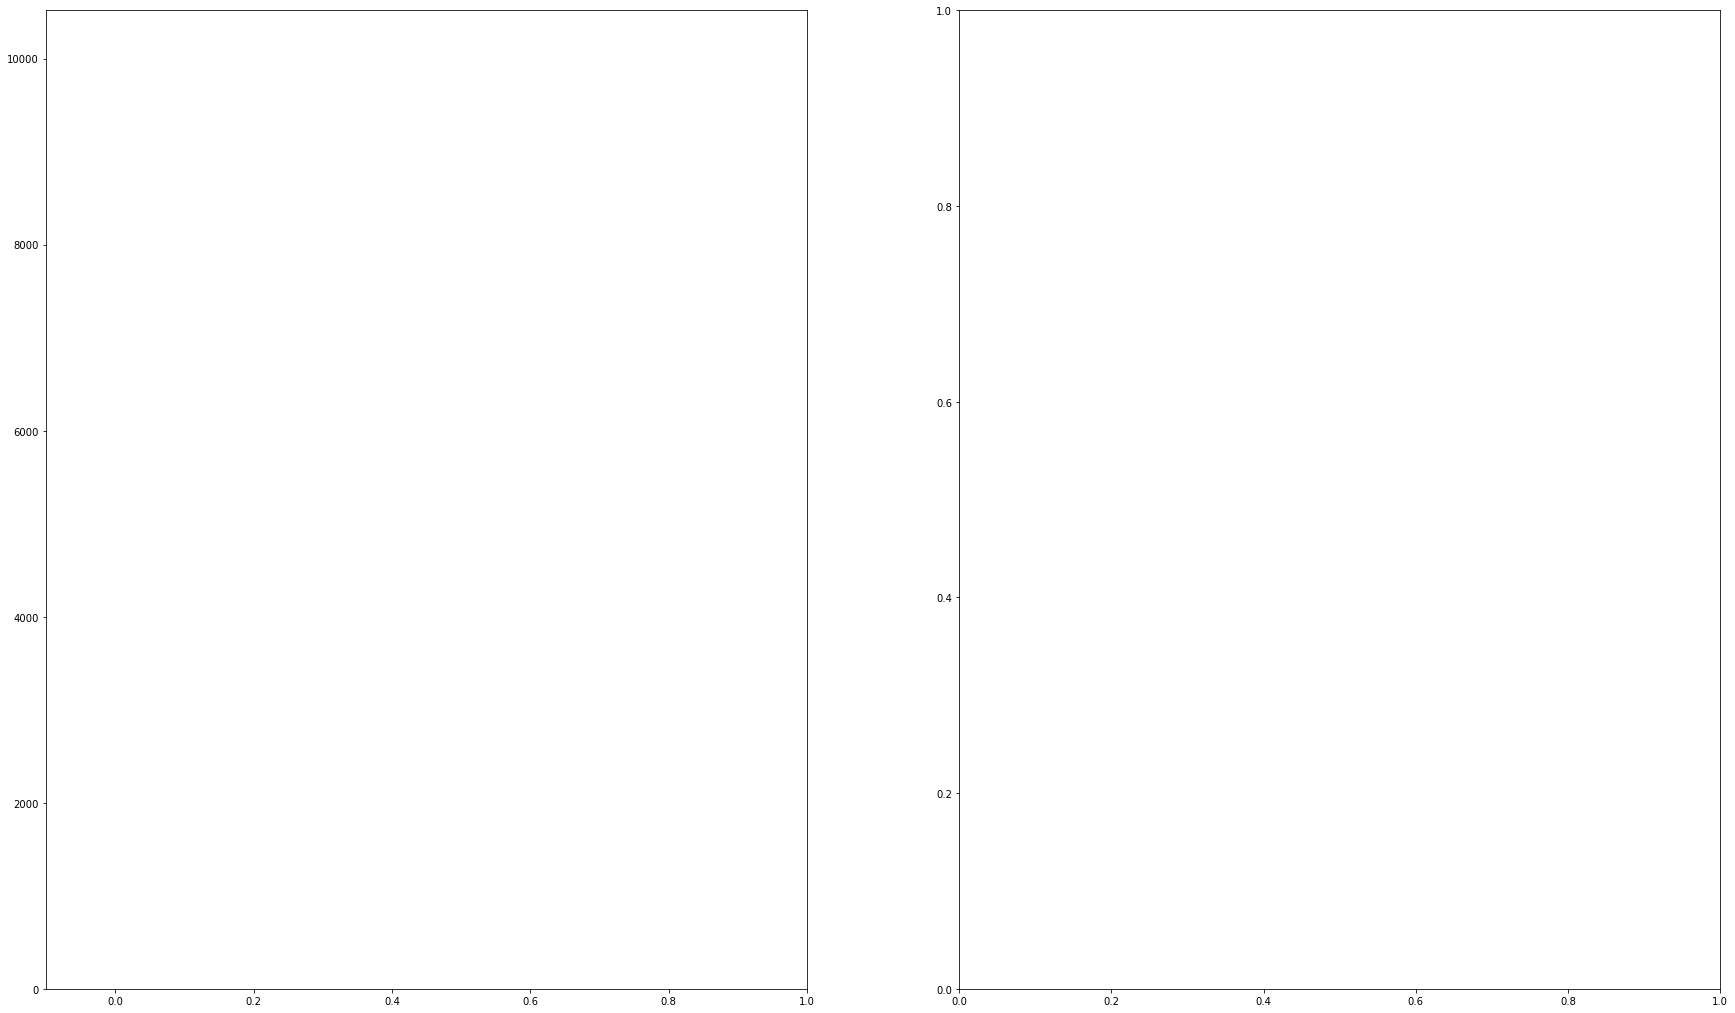

In [292]:
K_Means_silhouette_analysis(x,y)


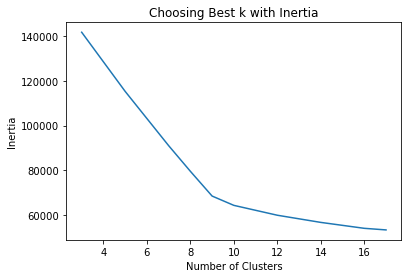

In [293]:
K_Means_inertia_analysis(x)


GMM: 

(10428, 17)


ValueError: expected square "a" matrix

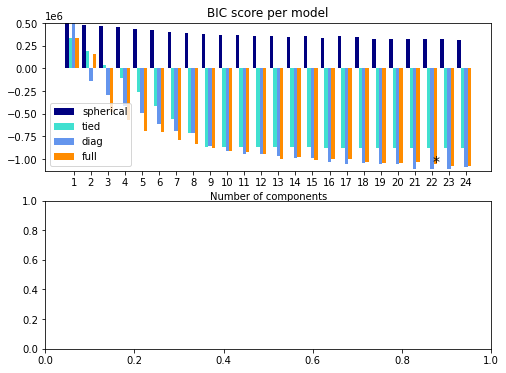

In [297]:
print('GMM: ')
print()
print(x.shape)
best_gmm_n = gmm_analysis(x,y)



In [449]:
# Create empty dictionary for AIC and BIC values

aic_score = {} 
bic_score = {}
# Loop through different number of clusters
for i in range(1,20): 
  # Create Gaussian Mixture Model
  gmm = GaussianMixture(n_components=i, random_state=0).fit(x)
  # Get AIC score for the model
  aic_score[i] = gmm.aic(x_pca)
  # Get BIC score for the model
  bic_score[i] = gmm.bic(x_pca)
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(aic_score.keys()),list(aic_score.values()), label='AIC')
plt.plot(list(bic_score.keys()),list(bic_score.values()), label='BIC')
plt.legend(loc='best')
plt.title('AIC and BIC from GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC values')
plt.show()
print(aic_score)
print(bic_score)

C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  """Predict the closest cluster each sample in X belongs to.


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jwadhwa\AppData\Local\Temp\ipykernel_35300\2985484052.py", line 10, in <cell line: 6>
    aic_score[i] = gmm.aic(x_pca)
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\mixture\_gaussian_mixture.py", line 845, in aic
    X : array of shape (n_samples, n_dimensions)
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\mixture\_base.py", line 373, in score
    """Predict the labels for the data samples in X using trained model.
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\mixture\_base.py", line 352, in score_samples
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\base.py", line 585, in _validate_data
    out = X, y
  File "C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\base.py", line 400, in _check_n_features
    ------

In [ ]:
GMM_Clustered_X = gmm_results(17,x,y)


In [597]:
# Dimensionality reduction ----
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test =\
  train_test_split(x, y, 
                   stratify=y, 
                   test_size=0.3, random_state=0)
sc = StandardScaler()

In [598]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [412]:
import numpy as np
cov_mat = np.cov(X_train_std.T)

# From this covariance matrix, caluclate the Eigenvalues and the Eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# print the Eigenvalues
print("Raw Eigenvalues: \n", eigen_vals)
# the sum of the Eigenvalues 
print("Percentage of Variance Explained by Each Component: \n", eigen_vals/sum(eigen_vals))

Raw Eigenvalues: 
 [2.78828729 1.84474541 0.00761148 0.31453217 0.55073759 0.60396258
 0.72758615 1.19221651 0.9065918  1.06992629 1.01662431]
Percentage of Variance Explained by Each Component: 
 [0.25295586 0.16735691 0.00069052 0.02853463 0.0499634  0.05479201
 0.06600725 0.10815892 0.0822468  0.09706465 0.09222905]


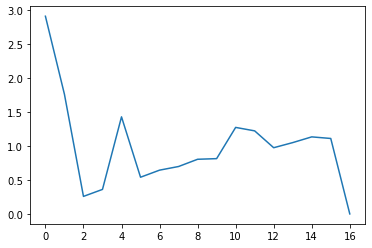

In [391]:
plt.plot(eigen_vals)

In [413]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.25295586, 0.42031277, 0.5284717 , 0.62553634, 0.71776539,
       0.80001219, 0.86601944, 0.92081145, 0.97077485, 0.99930948,
       1.        ])

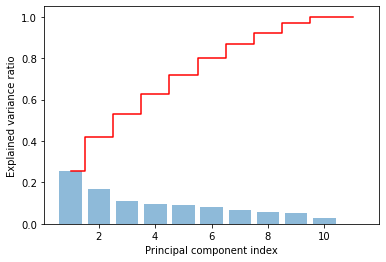

In [418]:
import matplotlib.pyplot as plt

plt.bar(range(1,12), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1,12), cum_var_exp, where='mid',
         label='Cumulative explained variance',
         color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

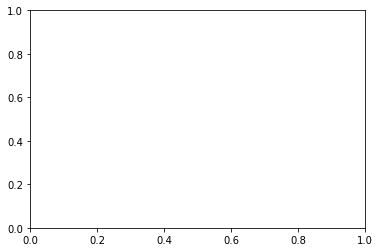

In [417]:
plt.bar(range(1,12), pca.explained_variance_ratio_,
        alpha=0.5,
        align='center')
plt.step(range(1,12), np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         color='red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.show()

Calculating Reconstruction Error


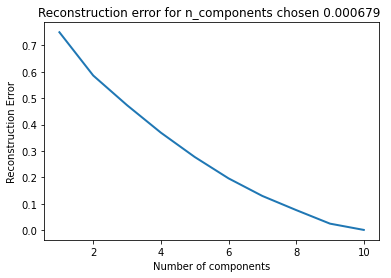

In [419]:
from sklearn.model_selection import GridSearchCV

print("Calculating Reconstruction Error")


reconstruction_error = []
n_components = range(1, X_train_std.shape[1])

for comp in n_components:

	pca = PCA(n_components = comp)
	X_transformed = pca.fit_transform(X_train)
	X_projected = pca.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

#	if(comp == GridSearchCV.best_estimator_.named_steps['pca'].n_components):
#
chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Starting PCA
Dimensionality reduction
best n_components=  9)


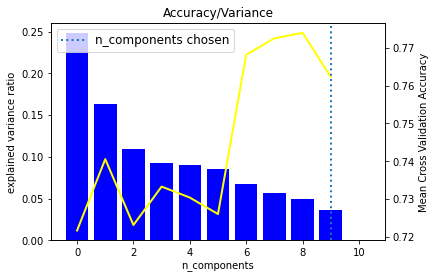

In [420]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy

print("Starting PCA")
print("Dimensionality reduction")

decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
pca = PCA()

pipe = Pipeline(steps=[('pca', pca), ('decisionTree', decisiontree)])

# Plot the PCA spectrum
pca.fit(x)

fig, ax = plt.subplots()
#ax.bar(list(range(1,X.shape[1])), pca.explained_variance_ratio_, linewidth=2, color = 'blue')
ax.bar(np.arange(x.shape[1]), pca.explained_variance_ratio_, linewidth=2, color = 'blue')
plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('explained variance ratio')

#Checking the accuracy for taking all combination of components
n_components = range(1, x.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(pca__n_components=n_components), cv = 3)
gridSearch.fit(x, y)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'yellow')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)


plt.legend(prop=dict(size=12))
plt.title('Accuracy/Variance')
print('best n_components=''  %d)'%gridSearch.best_estimator_.named_steps['pca'].n_components )
plt.show()

#Reducing the dimensions with optimal number of components
pca_new = PCA(n_components = gridSearch.best_estimator_.named_steps['pca'].n_components)
pca_new.fit(X_train)
X_train_transformed = pca_new.transform(X_train)
X_test_transformed = pca_new.transform(X_test)


In [421]:
import numpy as np
import scipy 
import sklearn.random_projection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA



# COV = (1/K)(X - X_mean).(X - X_mean)^T
def PCA(X, n):
    # getting 0 mean
    X_ = X - np.mean(X, axis = 1, keepdims = True)
    cov_X = (X_ @ X_.T) / (X.shape[1] - 1)
    evals, evecs = scipy.sparse.linalg.eigsh(cov_X, n)
    norm = LA.norm(evecs)
    evals = np.sqrt(evals)
    evals = 1 / evals
    evals = np.diag(evals)
    W = evals.dot(evecs.T)
    Z = W.dot(X_)    
    return W, Z, norm

def ICA(X):
    I_2 = np.identity(X.shape[0])
    W = np.identity(X.shape[0]) 
    const = 0.0001
    N = X.shape[1]
    for i in range(500):
        Y = W.dot(X)
        delta_w = (N*I_2-2*np.tanh(Y).dot(Y.T)).dot(W)
        W += const*delta_w
    return Y,W

def randomized_projections(X,n):
    projector = random_projection.GaussianRandomProjection(n_components=n)
    X_new = projector.fit_transform(X)
    return X_new

def NMF(X,n): 
    Dim1 = X.shape[0]
    Dim2 = X.shape[1]
    H = np.random.rand(n,Dim2)
    W = np.random.rand(Dim1,n) # so that X = W.H
    for i in range(100): 
        H = H * ((W.T.dot(X)) / (0.000001 + W.T.dot(W).dot(H))) # prevent division by 0
        W = W * ((X.dot(H.T)) / (0.000001 + W.dot(H).dot(H.T)))
    return W, W @ H

def Plot_2d(Z,Y): 
    for i in range(len(Y)):
        if Y[i] == 0:
            plt.scatter(Z[i, 1], Z[i, 0], color = 'r')
        elif Y[i] == 1:
            plt.scatter(Z[i, 1], Z[i, 0], color = 'b')
        elif Y[i] == 2:
            plt.scatter(Z[i, 1], Z[i, 0], color = 'g')
        elif Y[i] == 3:
            plt.scatter(Z[i, 1], Z[i, 0], color = 'k')
        elif Y[i] == 4:
            plt.scatter(Z[i, 1], Z[i, 0], color = 'c')
    plt.show()

def Plot_3d(Z,Y):
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(len(Y)):
        if Y[i] == 0:
            ax.scatter(Z[i, :][0], Z[i, :][1], Z[i, :][2], c = 'b', marker='o')
        elif Y[i] == 1:
            ax.scatter(Z[i, :][0], Z[i, :][1], Z[i, :][2], c = 'r', marker='o')
    plt.show()

def PCA_Analysis(pca):
    plt.figure()
    plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance')
    plt.title('Variance vs. Number of Components')
    plt.grid()
    plt.show()

def TSVD_Analysis(tsvd):
    plt.figure()
    plt.plot(np.arange(1, tsvd.explained_variance_ratio_.size + 1), tsvd.explained_variance_ratio_)
    plt.xticks(np.arange(1, tsvd.explained_variance_ratio_.size + 1))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance')
    plt.title('Variance vs. Number of Components')
    plt.grid()
    plt.show()

#### APPLYING DIM REDUCTION ALGORITHMS TO THE DATASET ###
PCA: 



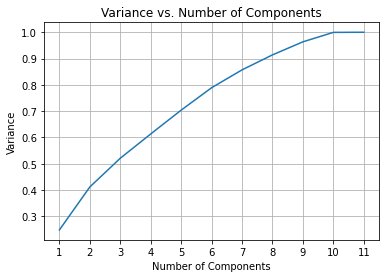

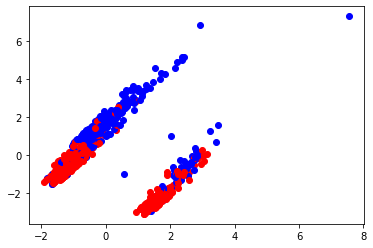

In [422]:
# Apply different dim reduction algorithms
print('#### APPLYING DIM REDUCTION ALGORITHMS TO THE DATASET ###')
### PCA ###
# Run a variance analysis to find the best number of components
print('PCA: ')
print()
pca = PCA_sk()
pca.fit(x)
PCA_Analysis(pca)
best_n = 9

# Visualize the data in 2d and 3d
Z_2d = PCA_sk(n_components = 2).fit_transform(x)
Plot_2d(Z_2d,y)

Z_3d = PCA_sk(n_components = 3).fit_transform(x)
#Plot_3d(Z_3d,y)

best_X_pca = PCA_sk(n_components = best_n).fit_transform(x)

In [433]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)

# fit_transform() to calculate the coordinate system
x_pca = pca.fit_transform(x)
X_train_pca = pca.fit_transform(X_train_std)
# transform() to apply that coordinate system
X_test_pca = pca.transform(X_test_std)

Training Data Overall Accuracy:  1.0
Test Data Overall Accuracy:  0.7777777777777778
Training Data Overall Accuracy:  1.0
Test Data Overall Accuracy:  0.8115942028985508


[]

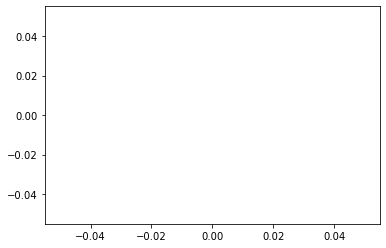

In [424]:
from sklearn.tree import DecisionTreeClassifier
dr = DecisionTreeClassifier(criterion='gini')
dr.fit(X_train_pca, y_train)

print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train_pca)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test_pca)))
plt.plot()

dr.fit(X_train,y_train)

print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test)))
plt.plot()


In [372]:
print(comps)

[[ 0.39479143  0.05792852  0.0977926   0.39521299  0.40557478  0.35015464
   0.28971434  0.33960434  0.34099559 -0.03938816  0.26614511]
 [ 0.1890252   0.09909259  0.06517529  0.12933695  0.22272082  0.27408743
   0.18478771 -0.60891566 -0.6065724   0.11335205  0.15179669]
 [ 0.09984816 -0.38203027  0.08692714  0.41715954  0.28713951 -0.35949107
  -0.03001202 -0.10126187 -0.09990146 -0.46682612 -0.46017417]
 [-0.14907851 -0.43832169  0.62059444 -0.28437731 -0.17686092  0.03919833
   0.4649754  -0.02179431  0.02100009 -0.17513357  0.19757431]
 [ 0.09192153  0.5686215   0.70116629  0.08617412 -0.04241271 -0.11721275
  -0.12663742  0.0019965   0.05095328  0.1524101  -0.33429943]
 [ 0.01986819  0.48530318 -0.1096501  -0.13464625 -0.16125815  0.05842633
   0.08782279 -0.03783305 -0.03762645 -0.81873483  0.15371674]
 [ 0.06189338 -0.19680974  0.28778654  0.09655793  0.01368036  0.05216476
  -0.76251901 -0.03759896 -0.0292975  -0.15236498  0.50543045]
 [-0.81574349  0.18578033  0.05022201  0.

For n_clusters =  3 The average silhouette_score is : 0.21176037539221387
For n_clusters =  5 The average silhouette_score is : 0.21462646576645744
For n_clusters =  7 The average silhouette_score is : 0.22707235244366358
For n_clusters =  8 The average silhouette_score is : 0.19694263223828015
For n_clusters =  9 The average silhouette_score is : 0.20969513348465696
For n_clusters =  10 The average silhouette_score is : 0.21329164145320834
For n_clusters =  12 The average silhouette_score is : 0.2156909089275851
For n_clusters =  14 The average silhouette_score is : 0.19280851763189719
For n_clusters =  16 The average silhouette_score is : 0.19921226227874755
For n_clusters =  17 The average silhouette_score is : 0.19444139343812308


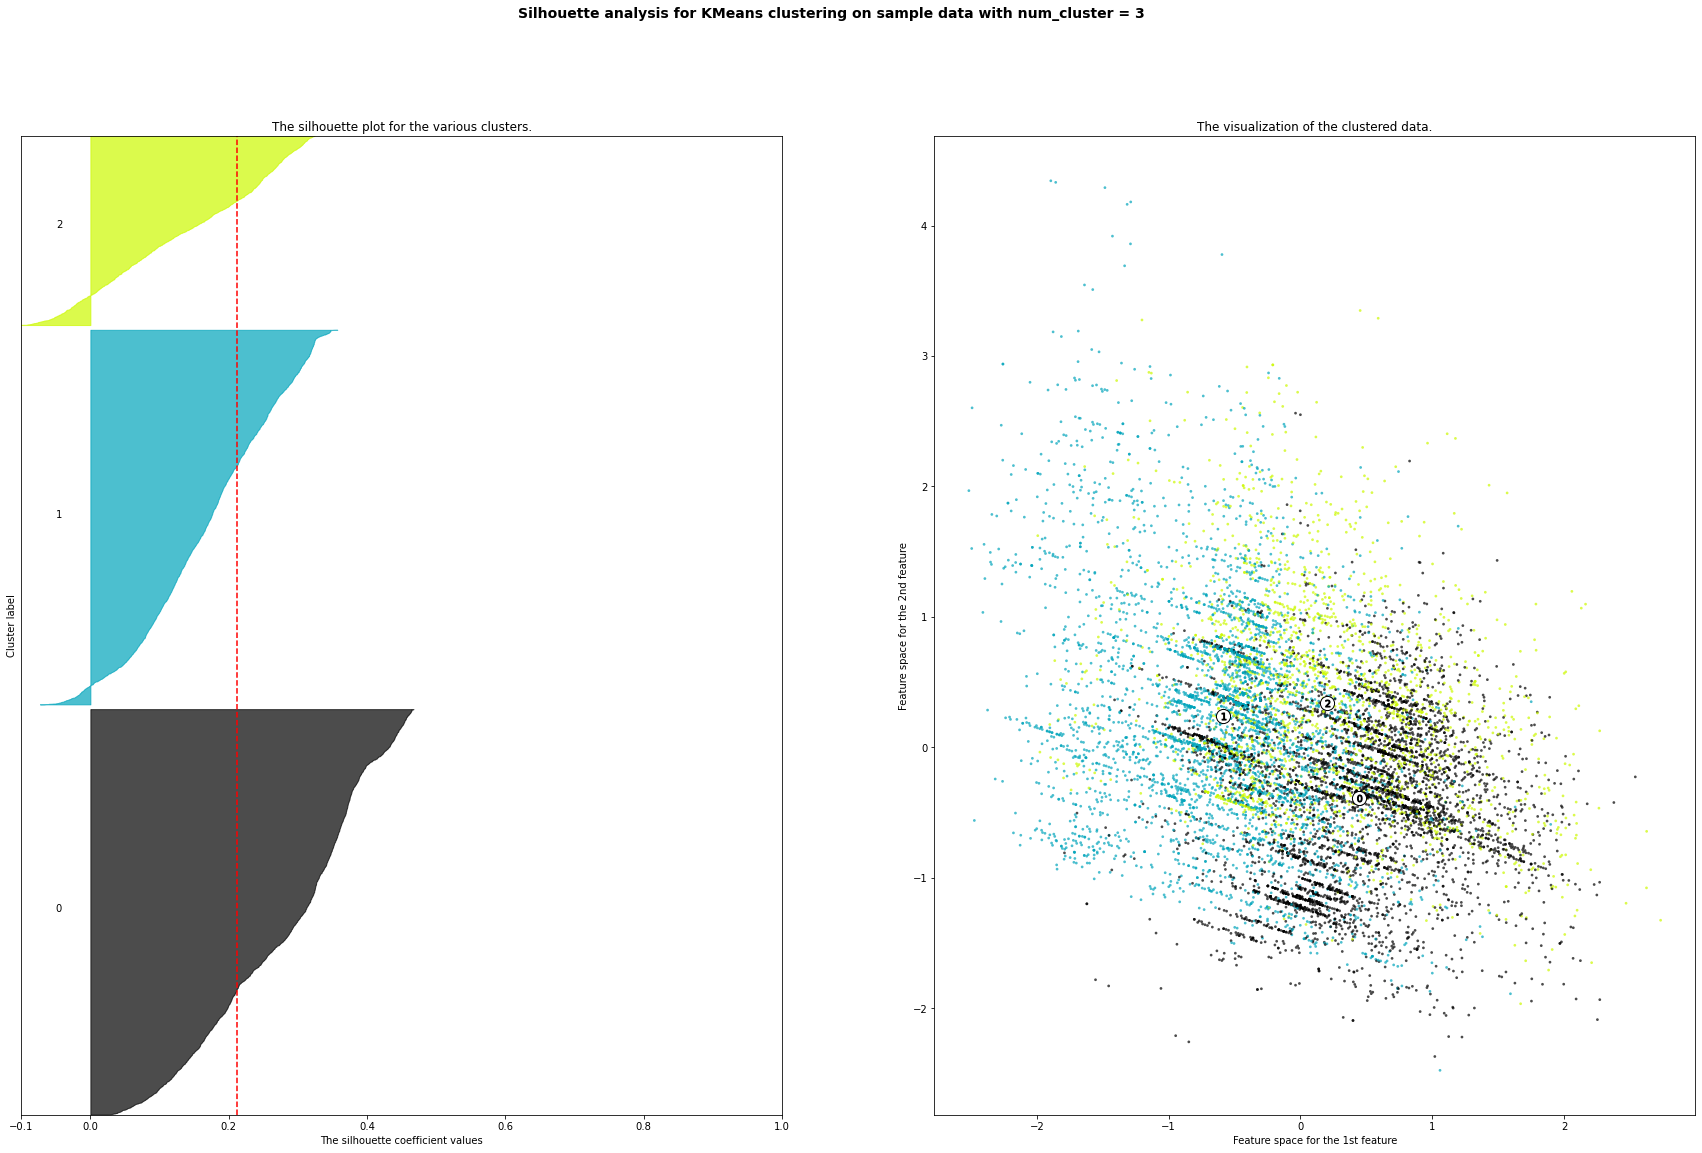

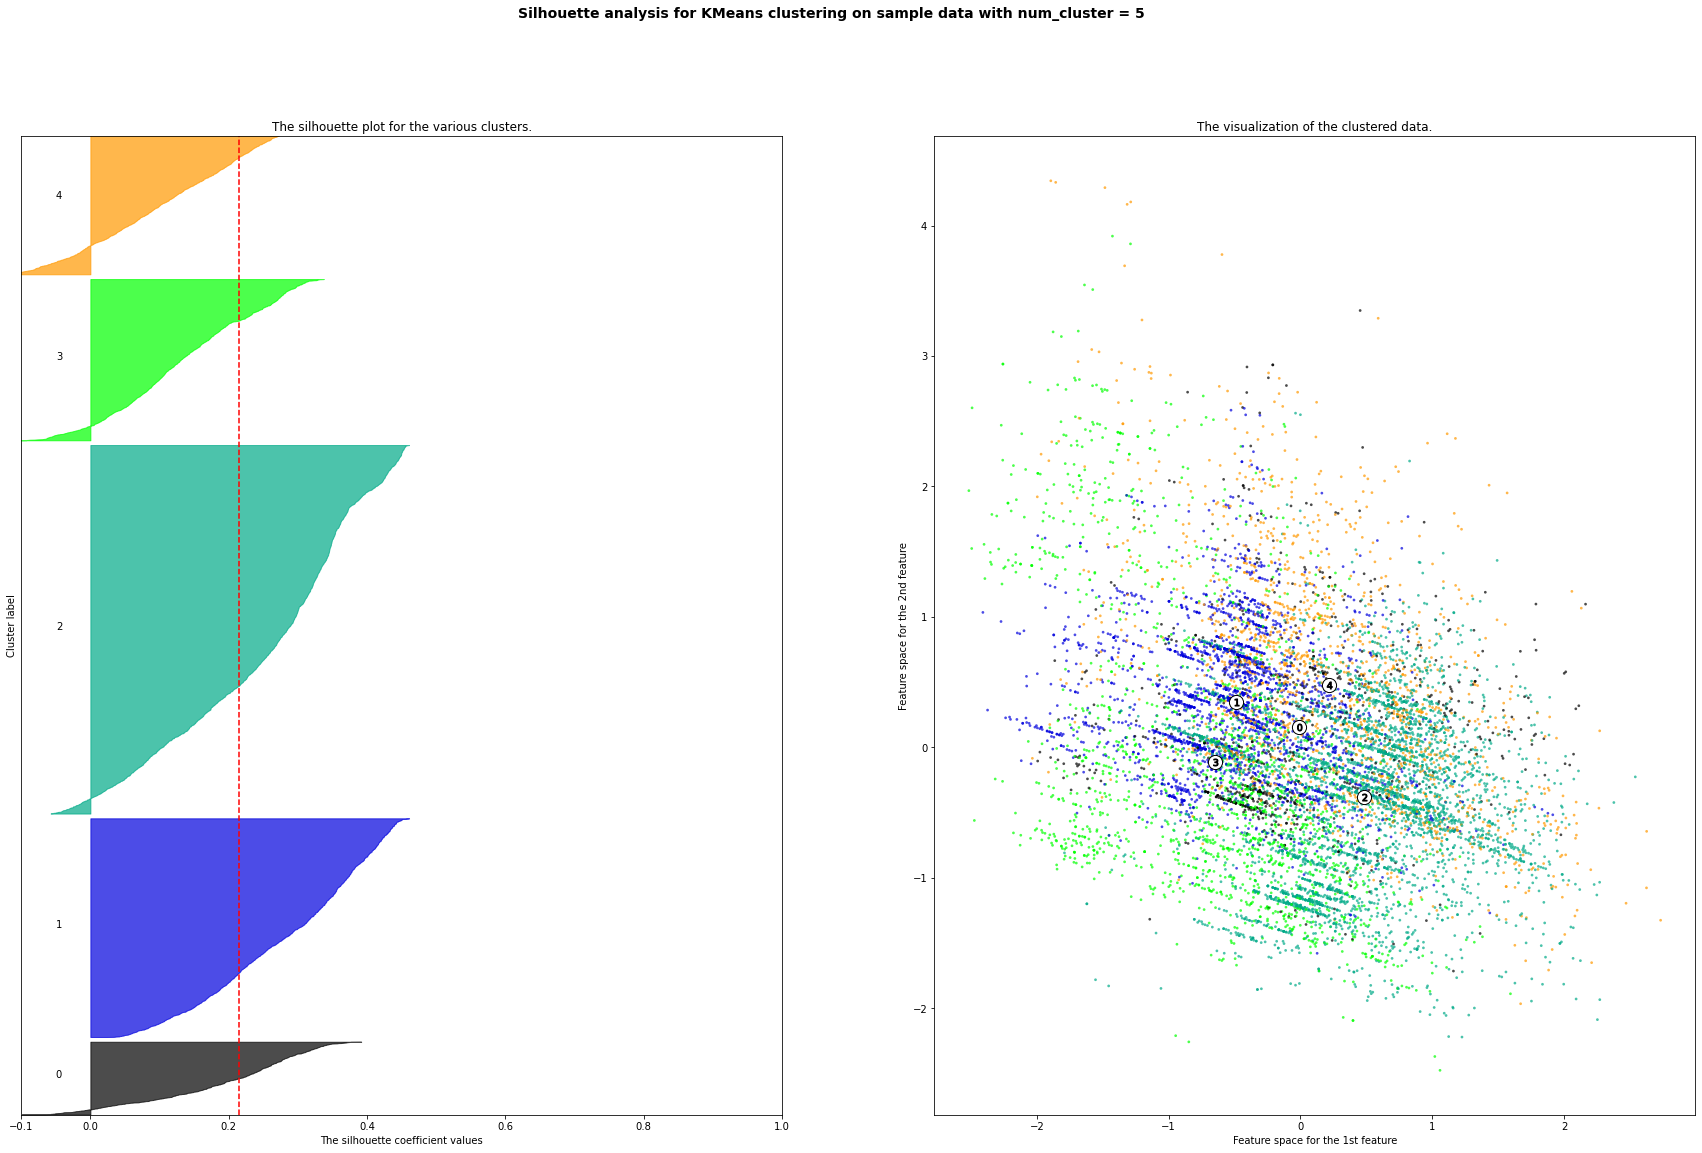

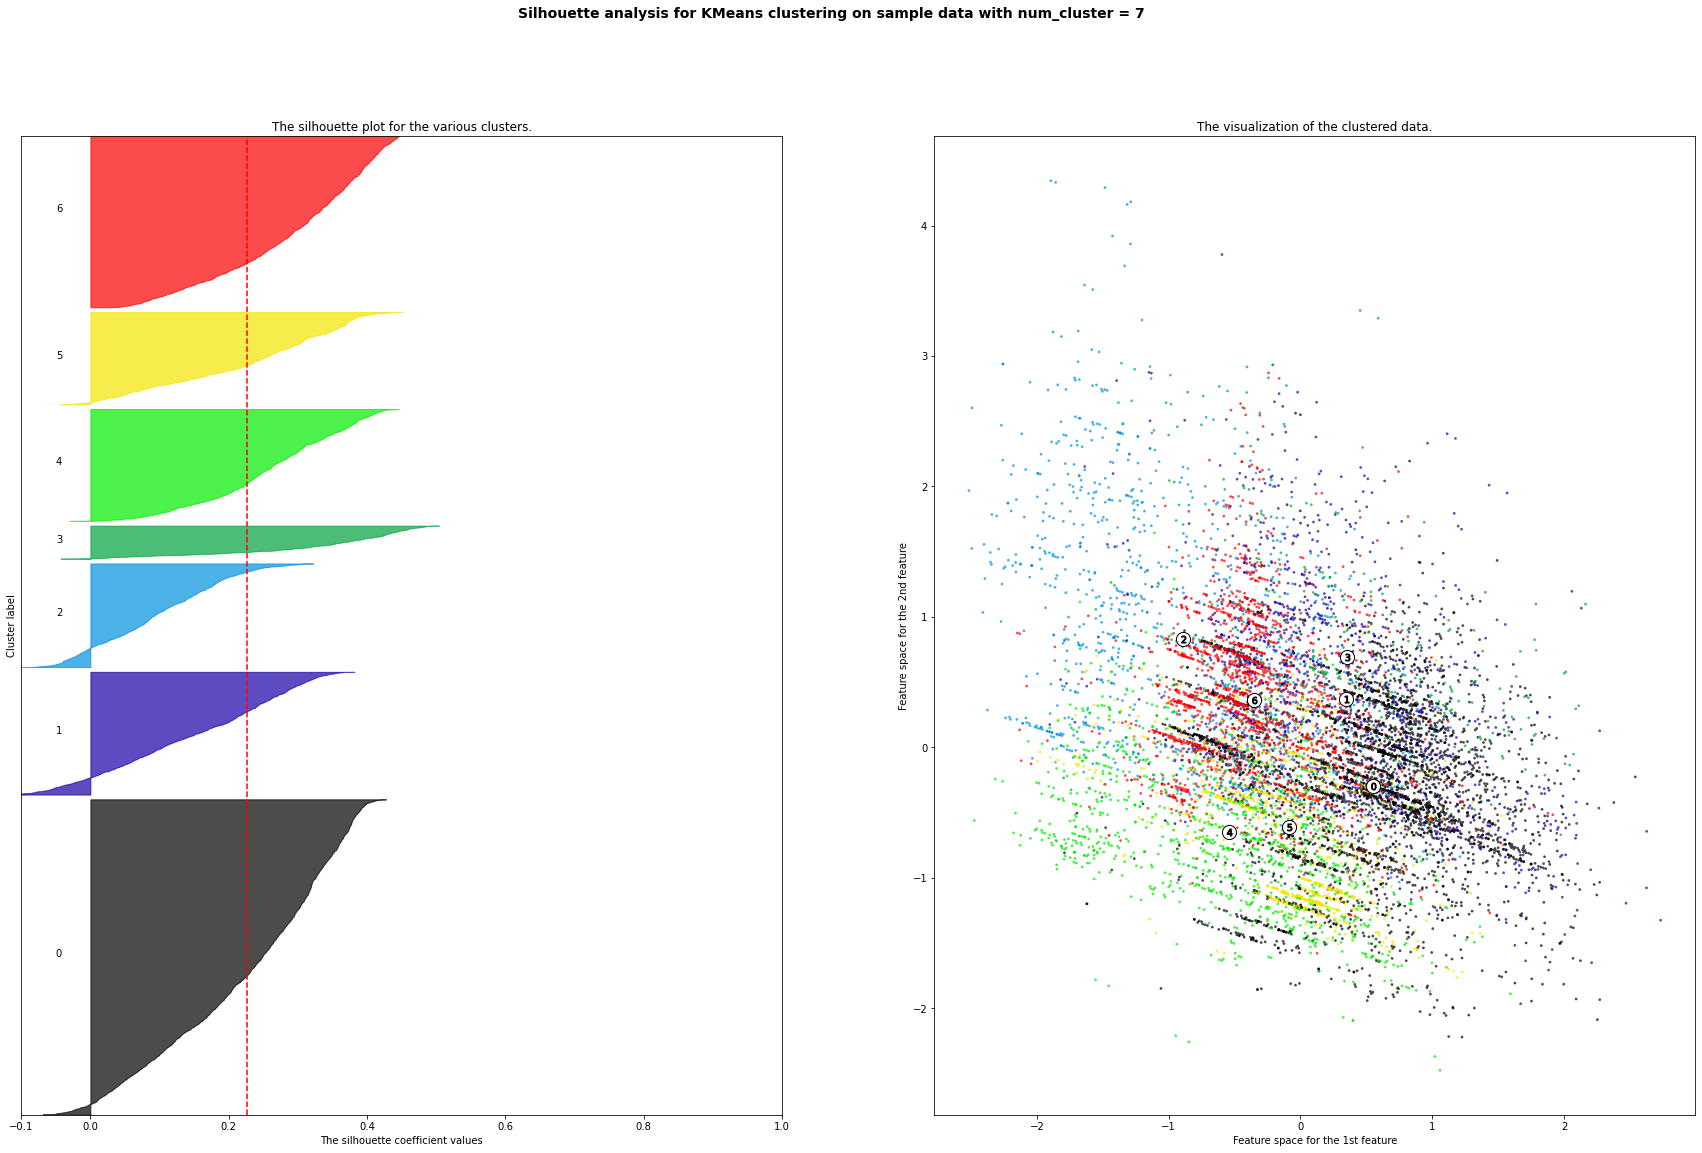

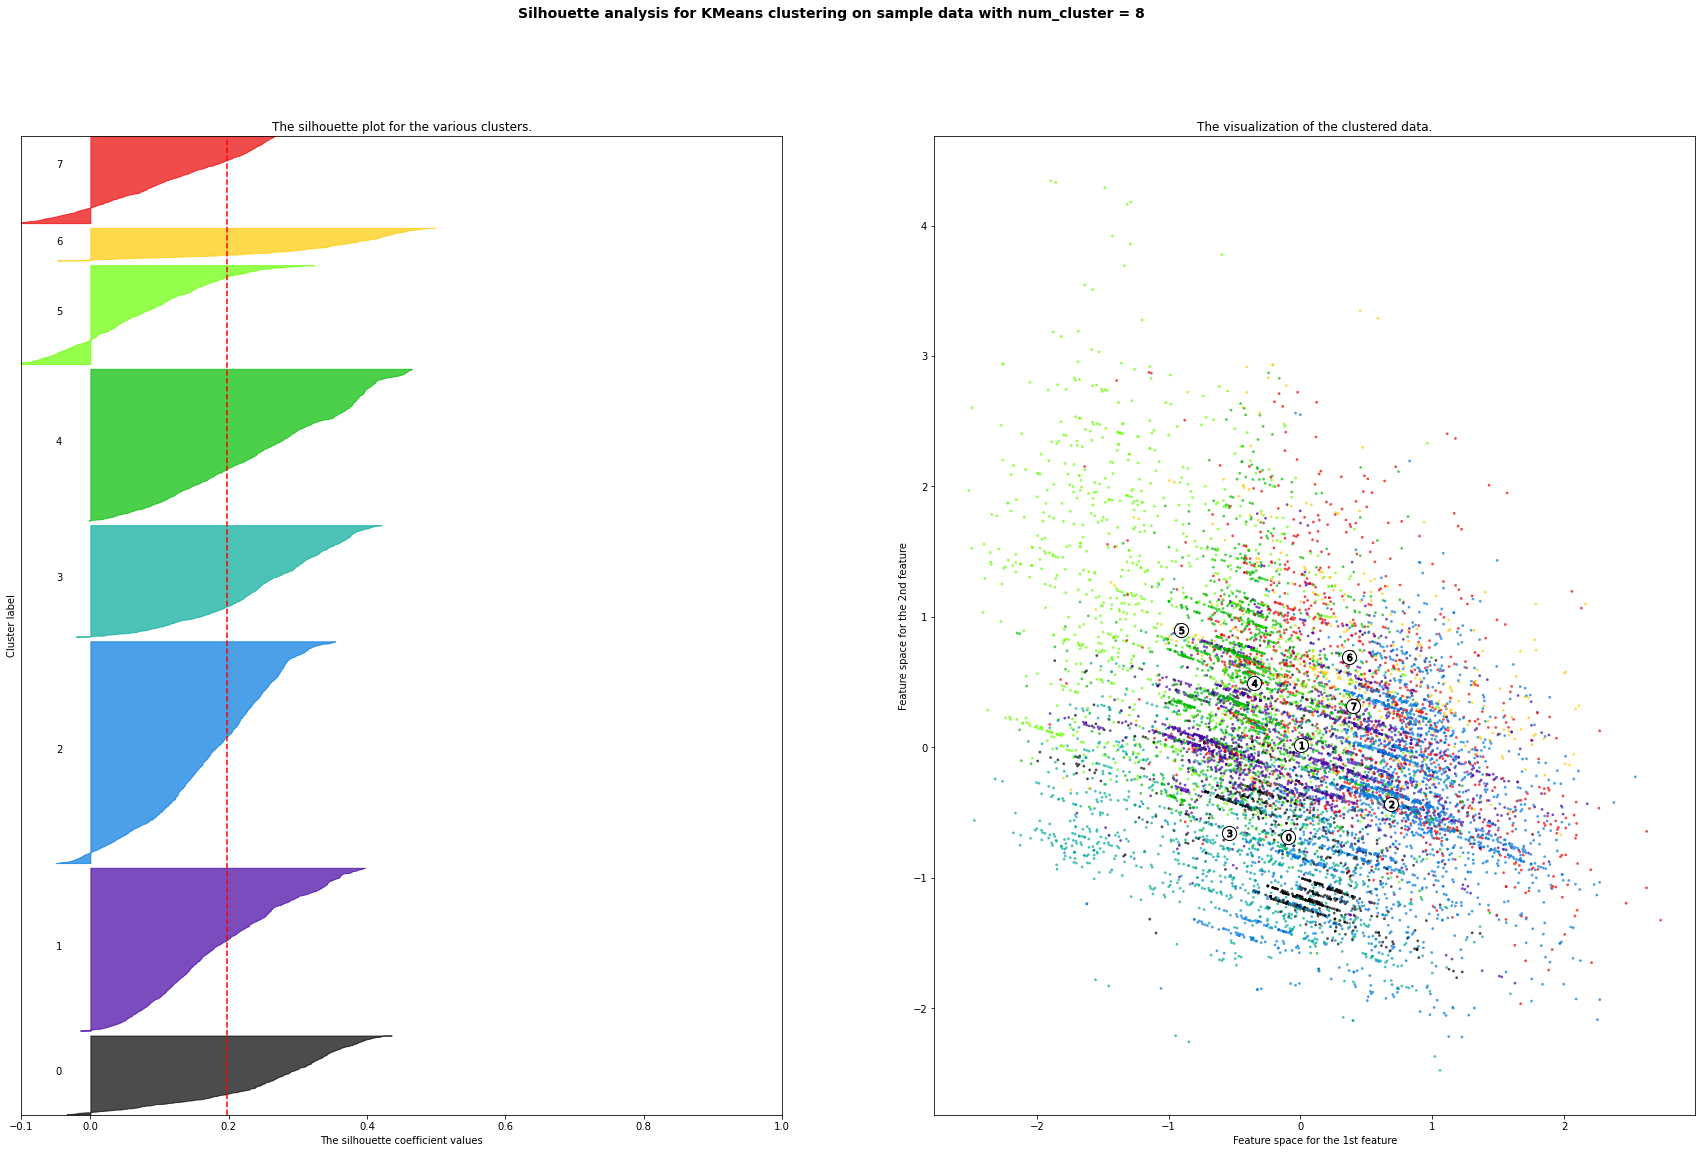

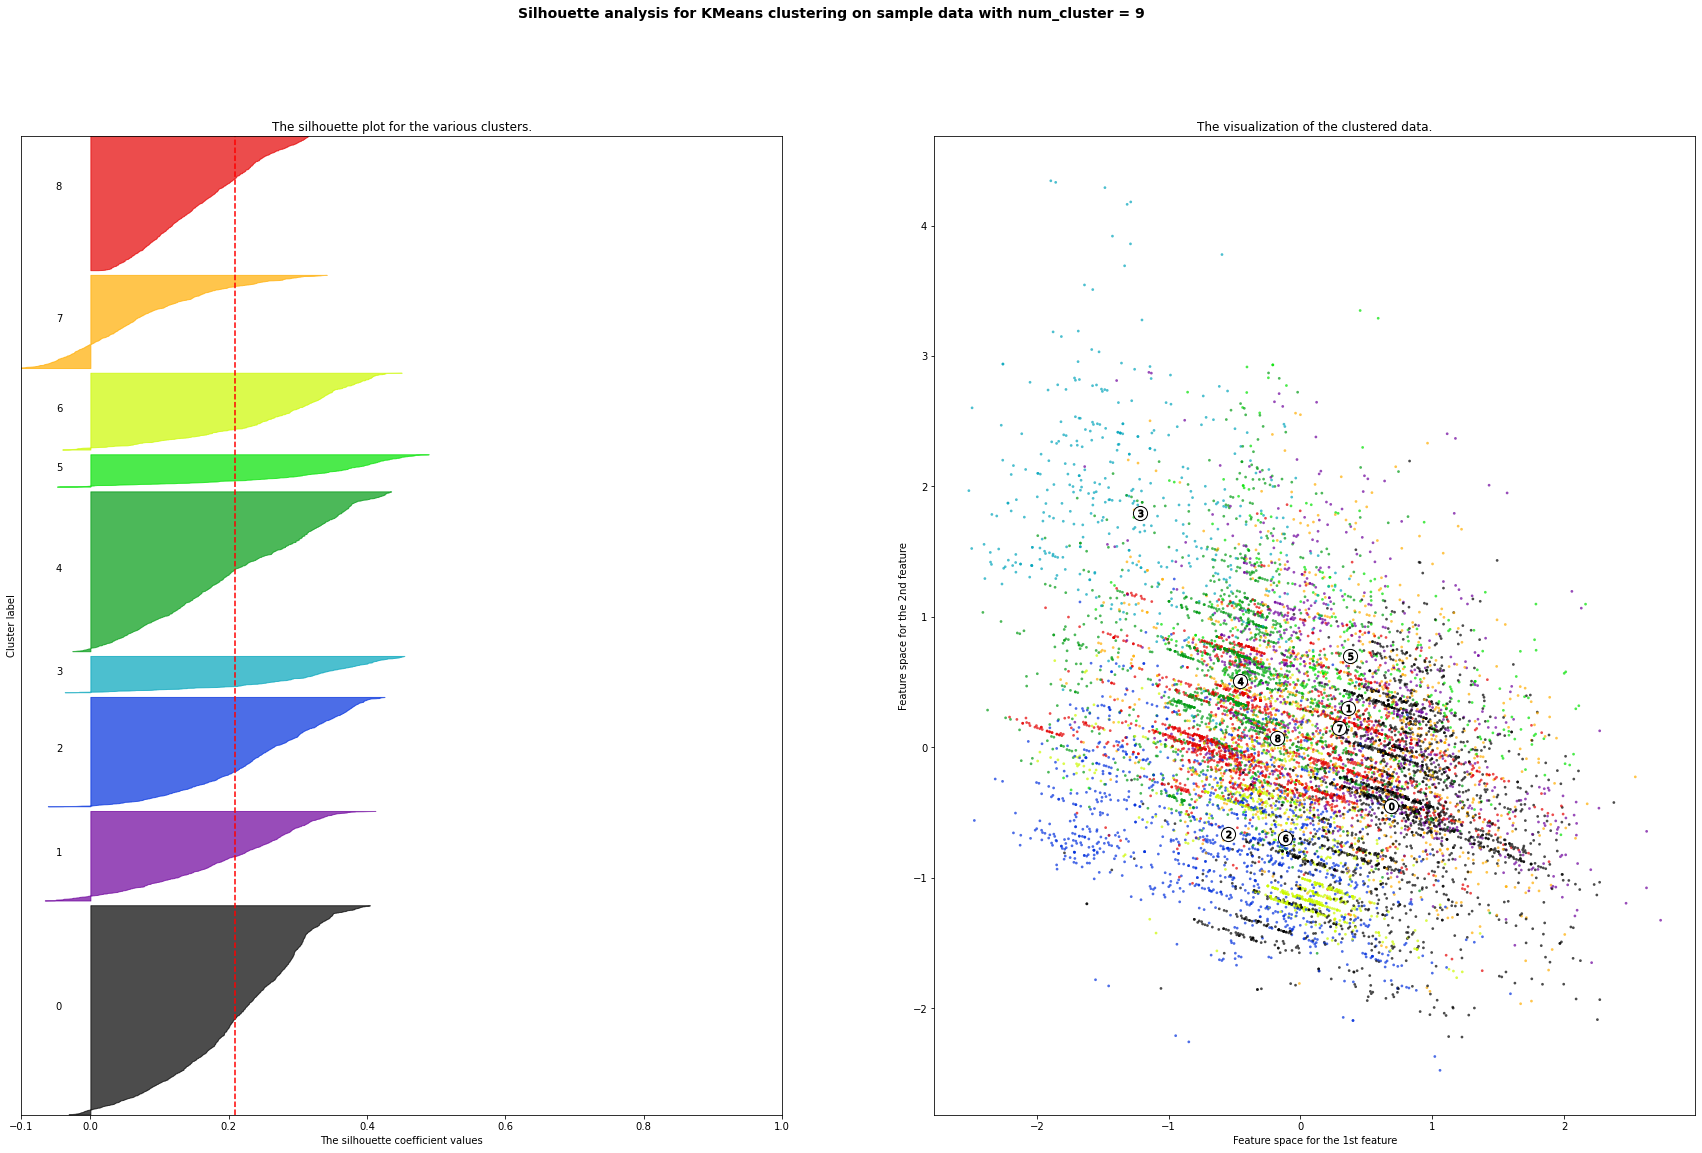

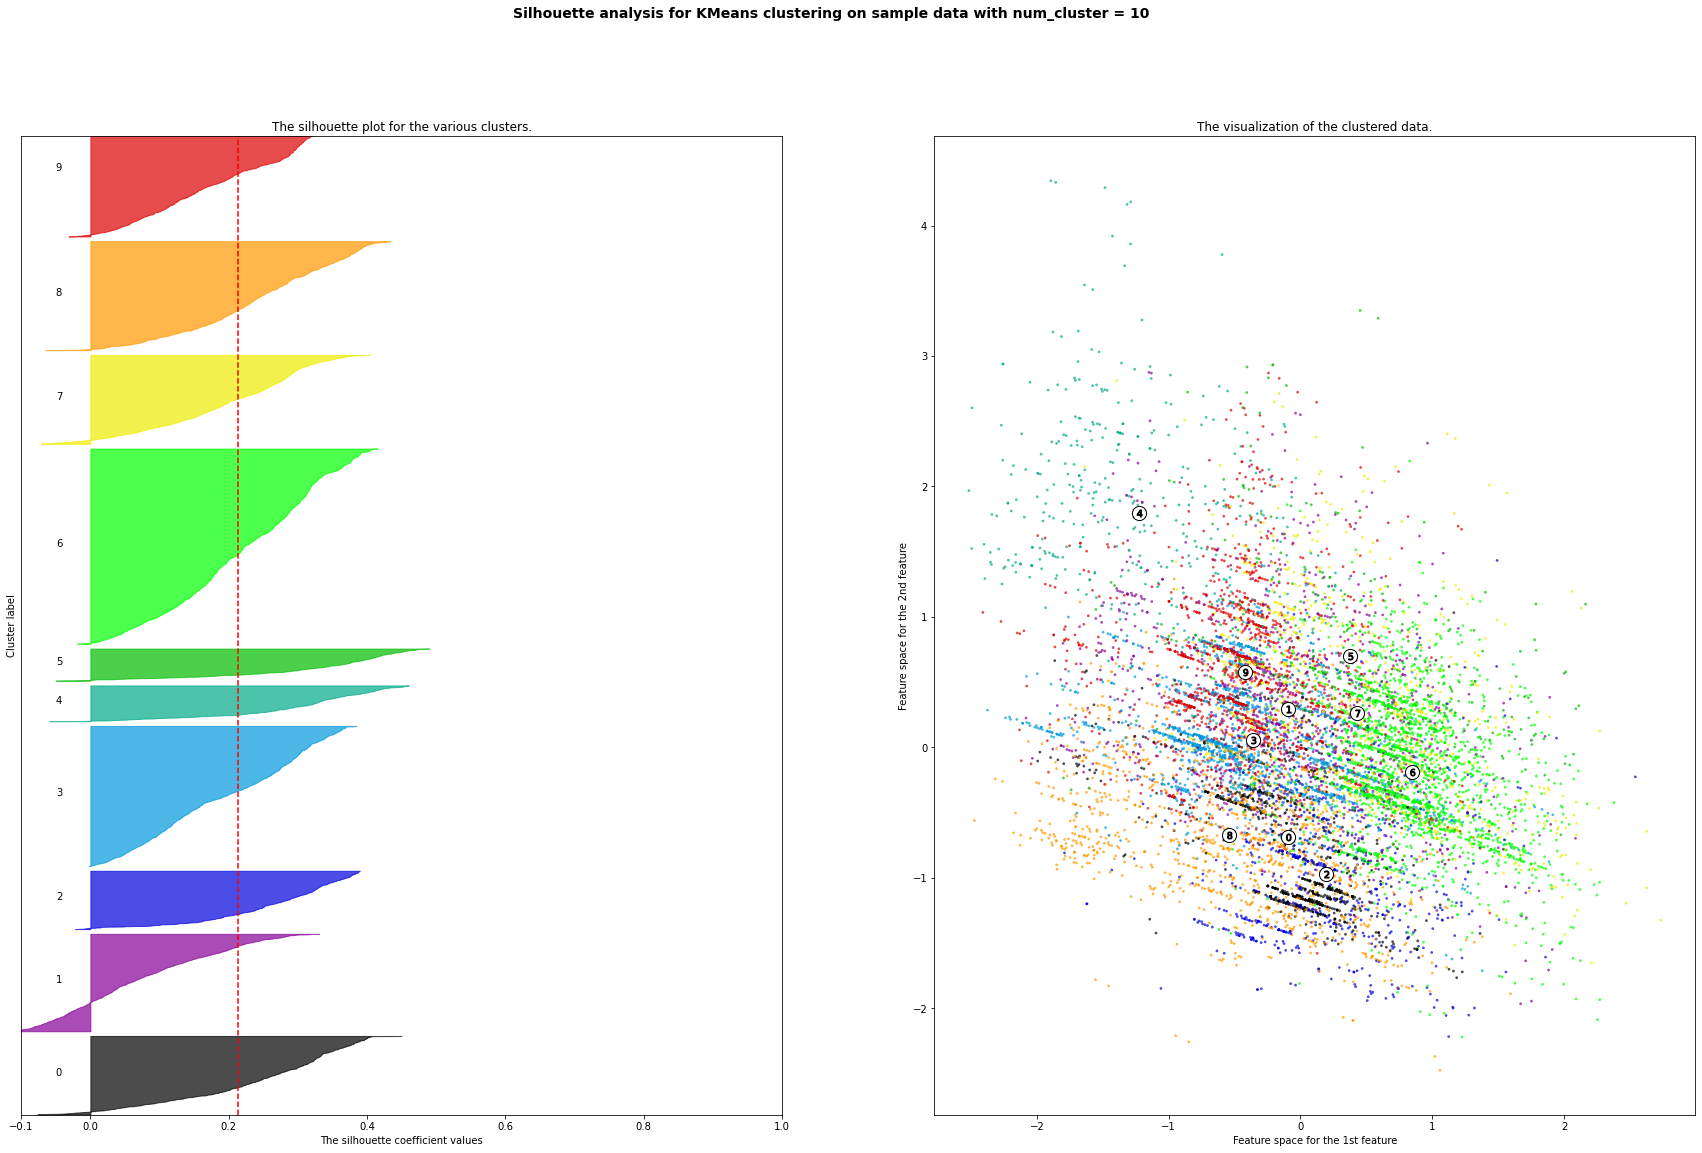

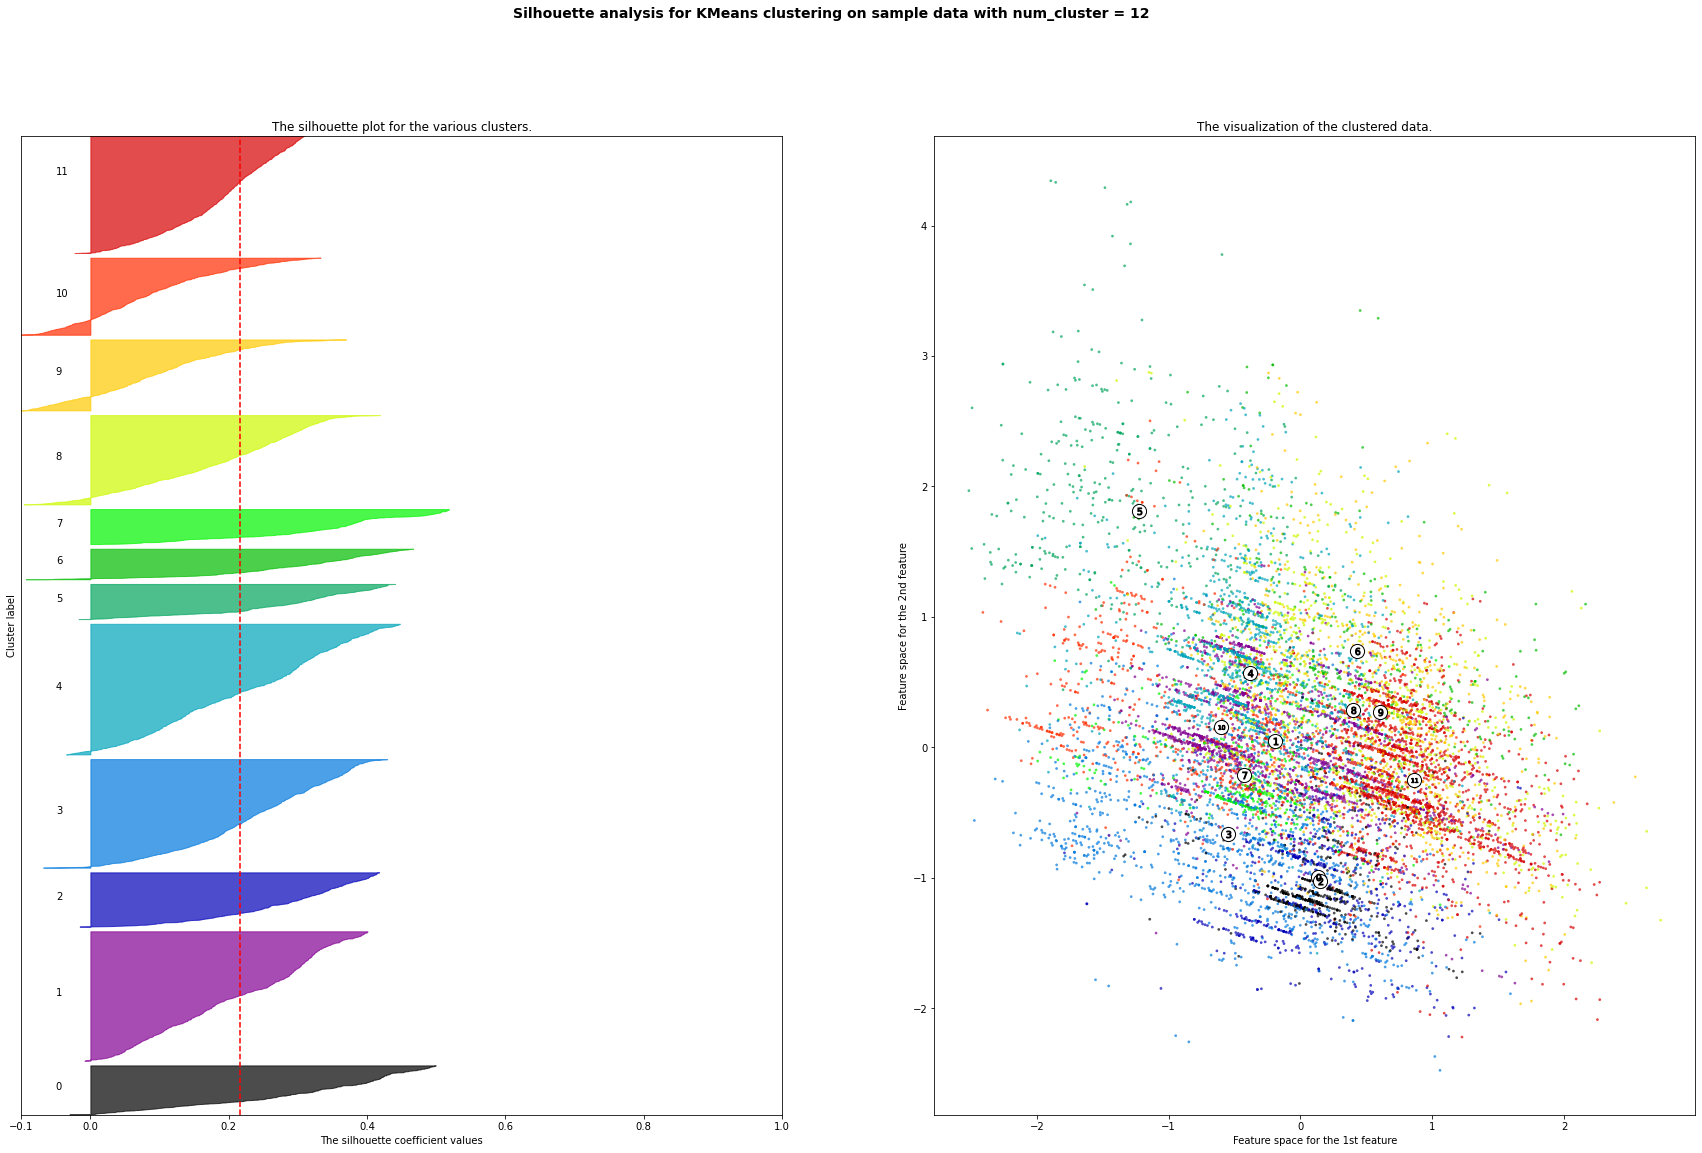

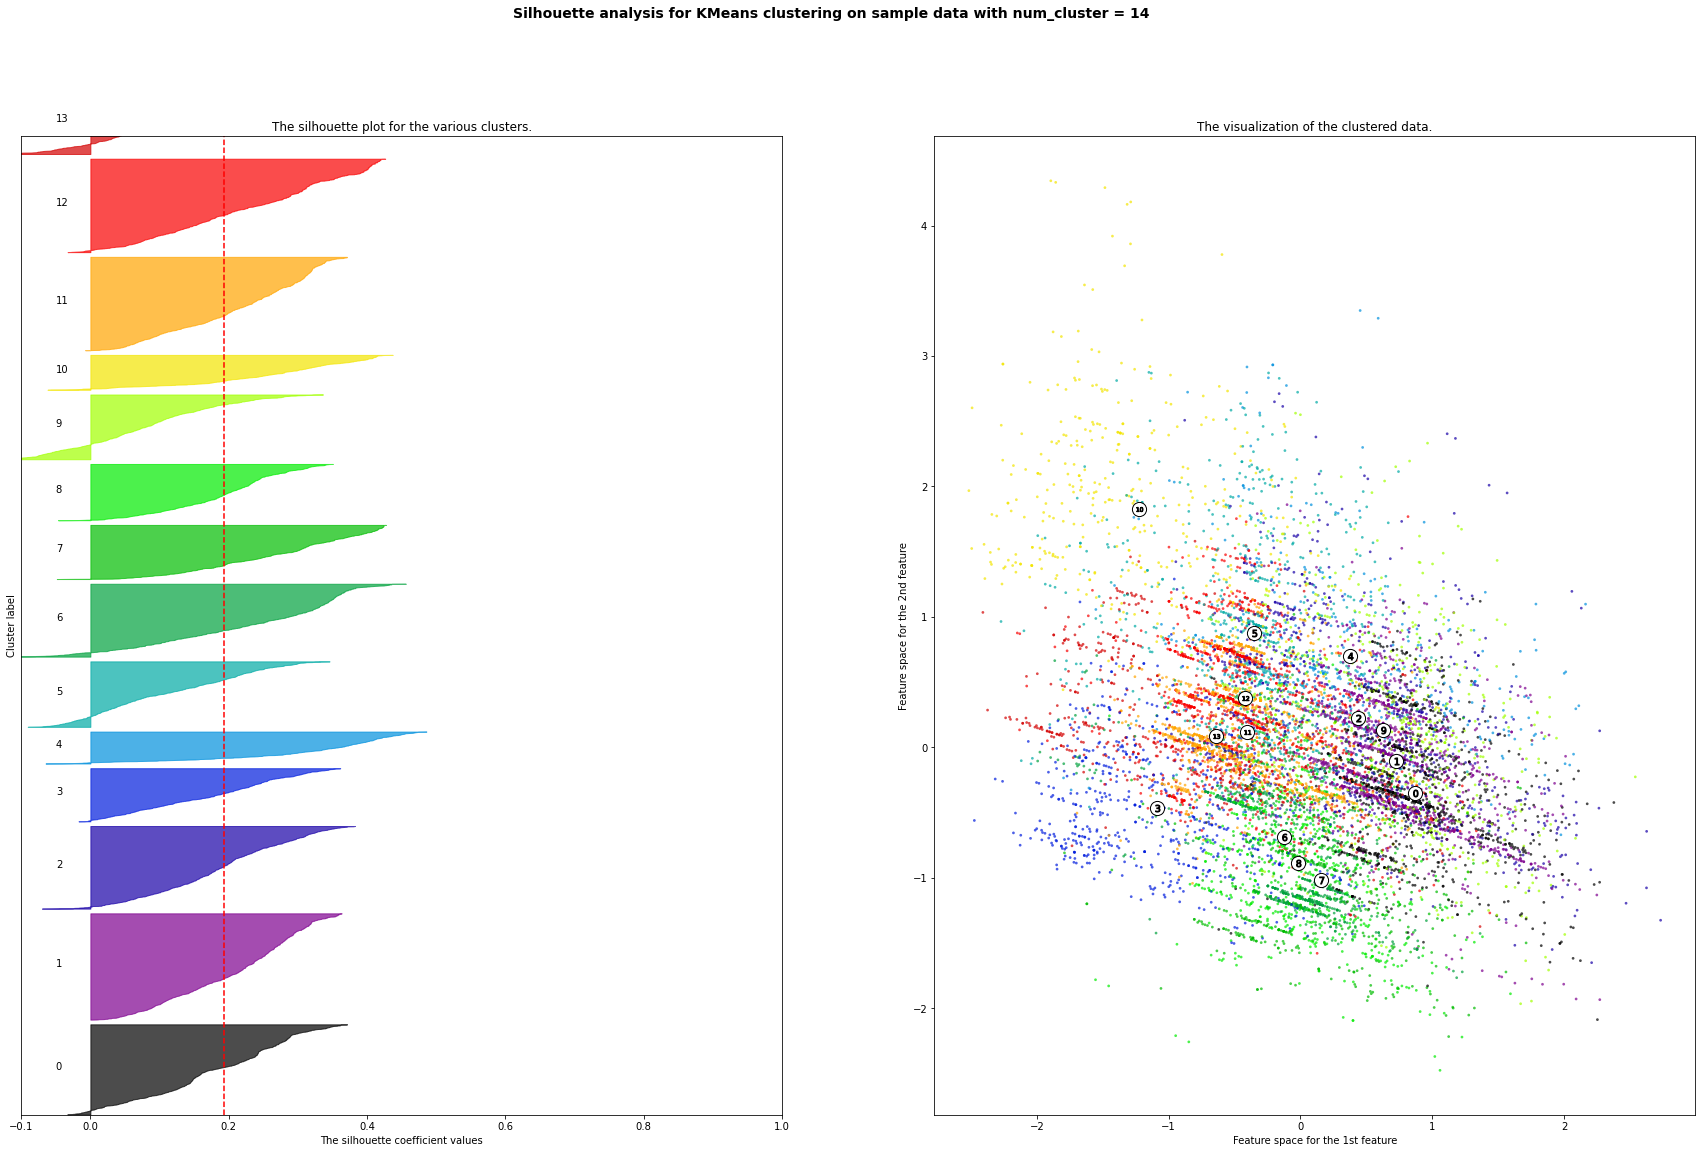

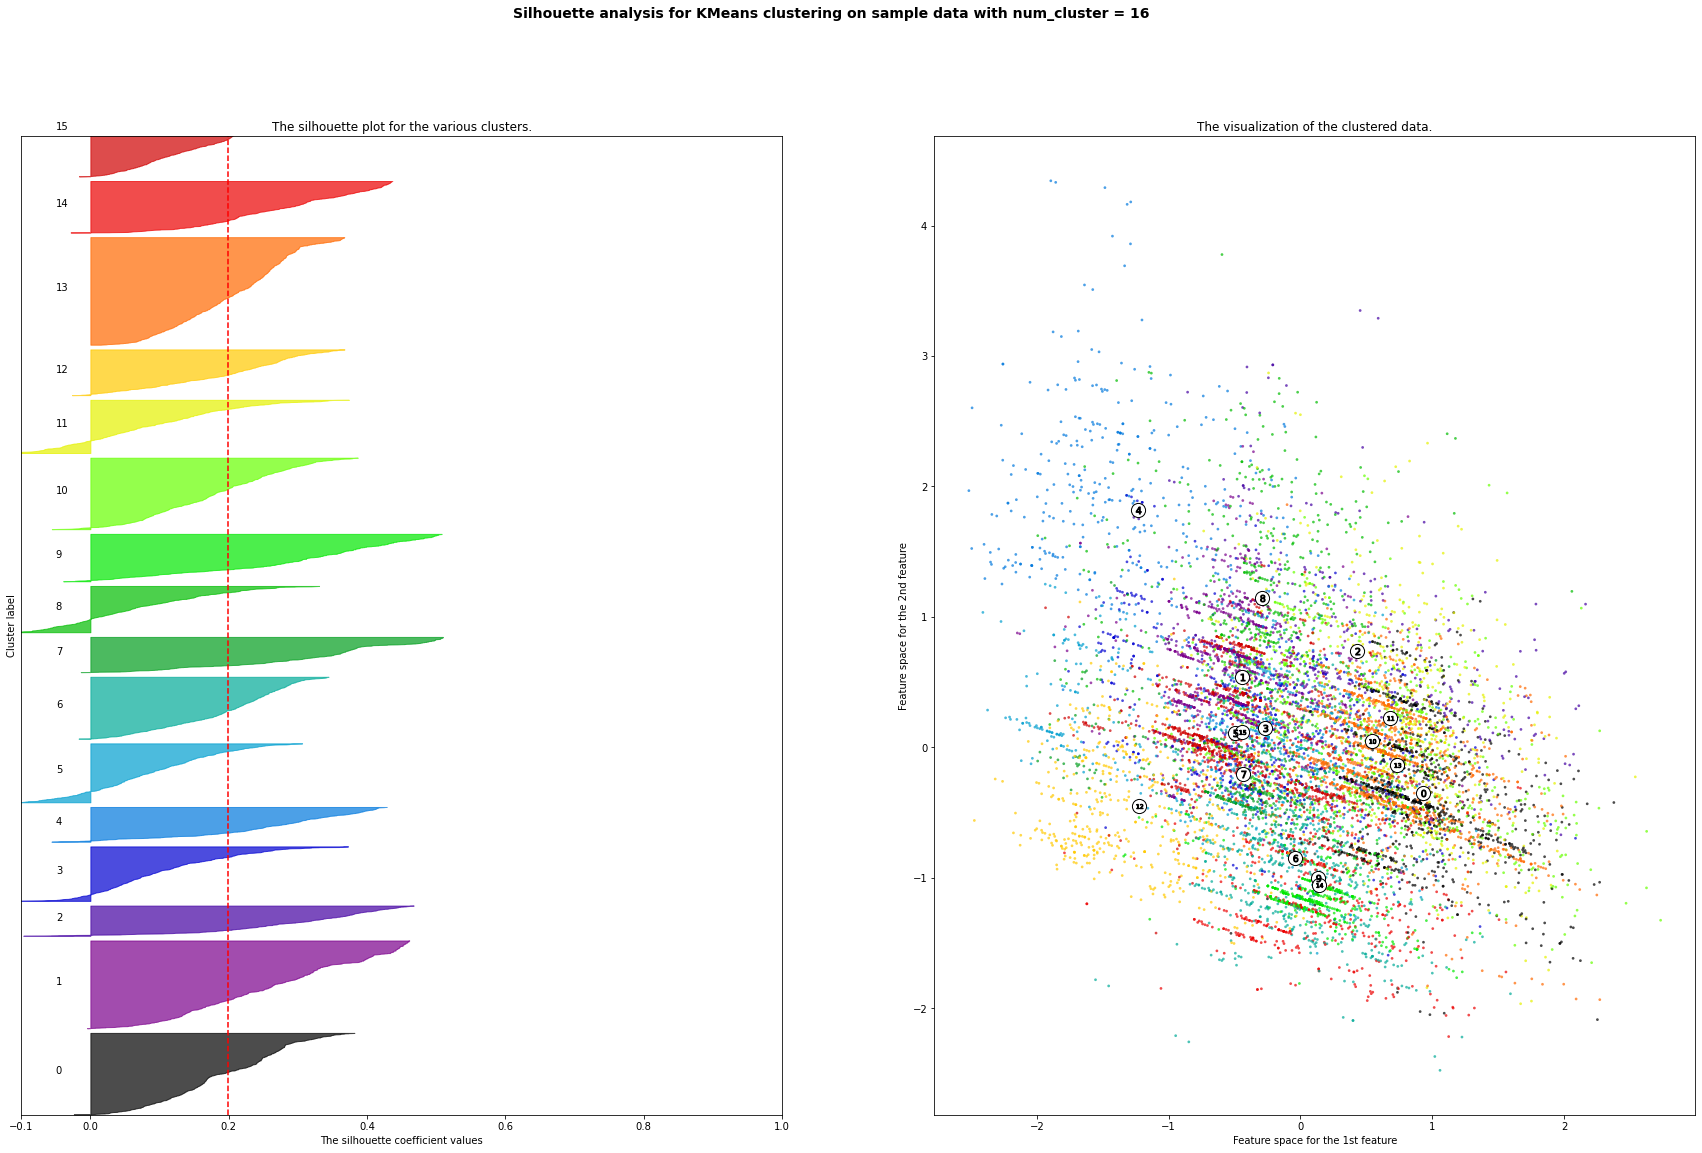

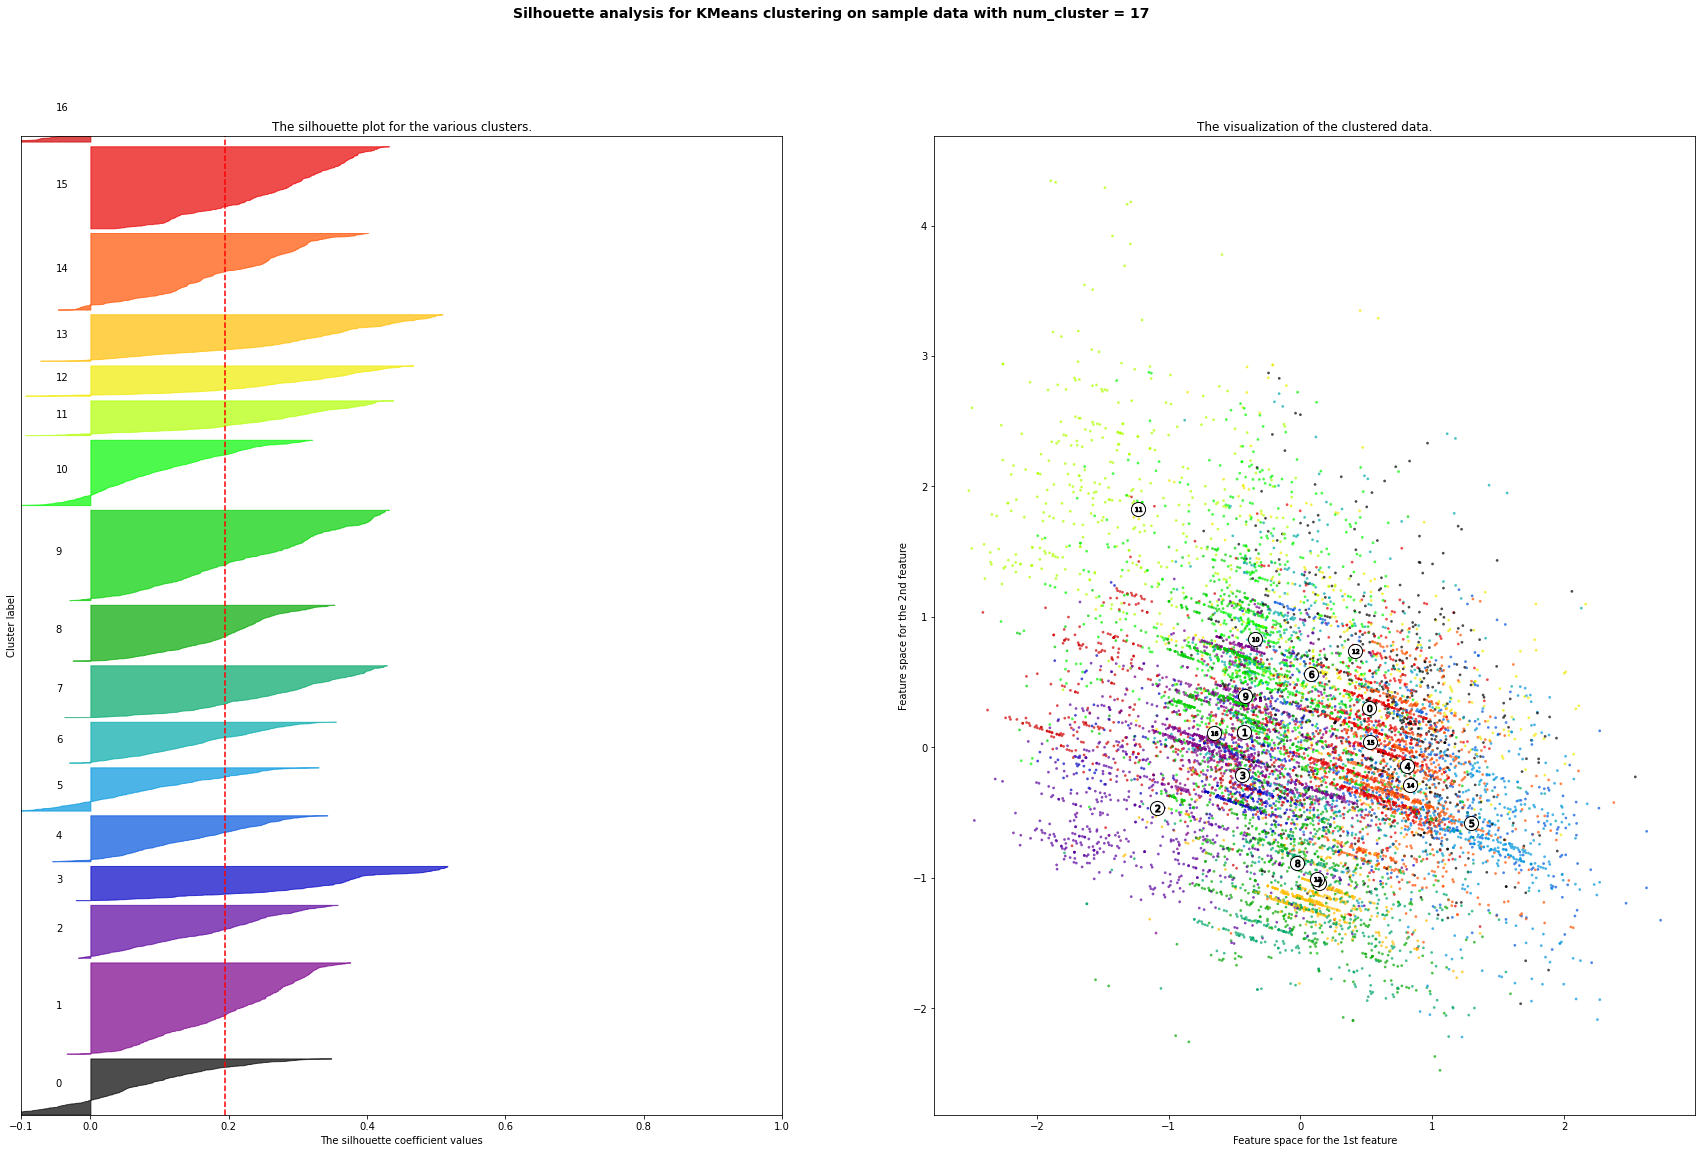

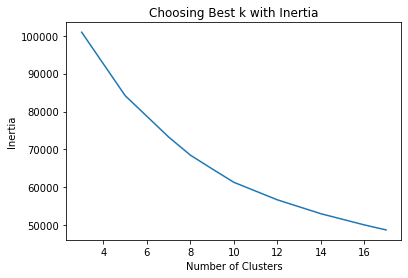

In [602]:
K_Means_silhouette_analysis(x_rp,y)
K_Means_inertia_analysis(x_rp)
#K_Means_Results(32,x_ica,y)





C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  """Predict the closest cluster each sample in X belongs to.
C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  """Predict the closest cluster each sample in X belongs to.
C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  """Predict the closest cluster each sample in X belongs

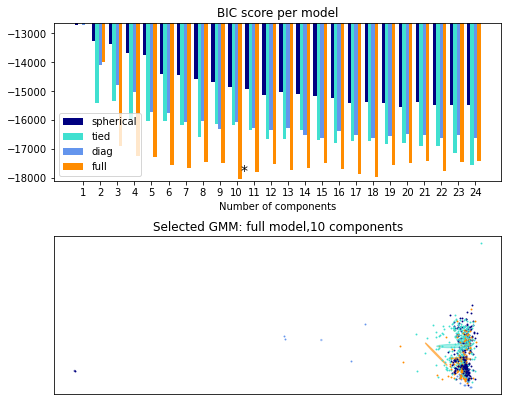

In [546]:
best_gmm_n = gmm_analysis(x_ica,y)

#gmm_results(4,x_pca,y)


ICA: 



C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  # np.einsum allows having the lowest memory footprint.


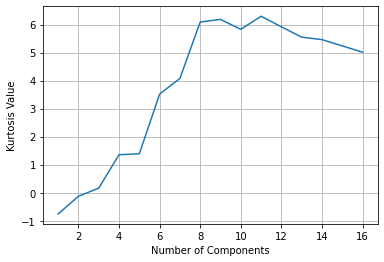

In [557]:
print('ICA: ')
print()
kurtosis_analysis(x)
#Z_2d = FastICA(n_components = 2).fit_transform(x)
##Plot_2d(Z_2d,y)

#Z_3d = FastICA(n_components = 3).fit_transform(x)
##Plot_3d(Z_3d,y)

#best_X_ica = FastICA(n_components = best_n).fit_transform(x)


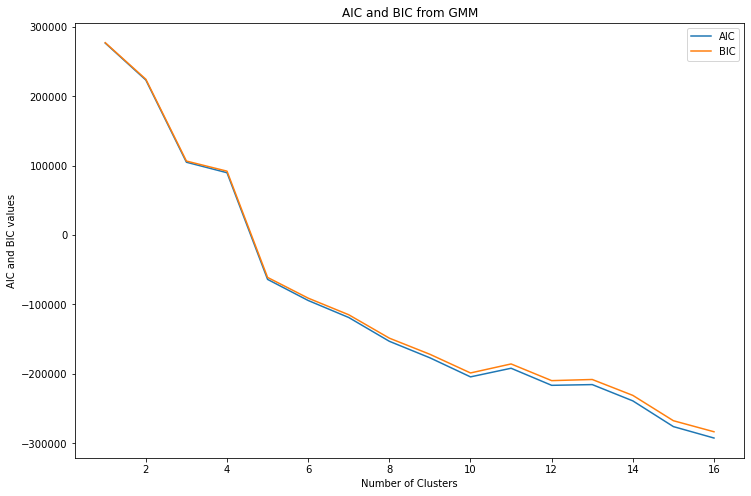

{1: 276748.0481049402, 2: 223493.22186469374, 3: 105019.11734933735, 4: 89892.90699684102, 5: -63817.9820992398, 6: -94222.20494364624, 7: -118750.7844047027, 8: -153022.84917199513, 9: -176847.14736452713, 10: -204311.90476031983, 11: -191879.5046269554, 12: -216496.82643221098, 13: -215425.47379994986, 14: -238896.5747029977, 15: -275985.8698124591, 16: -292444.94259310374}
{1: 277306.47133761935, 2: 224617.320579827, 3: 106708.89154692479, 4: 92148.35667688263, 5: -60996.85693674403, 6: -90835.4042986963, 7: -114798.30827729861, 8: -148504.69756213686, 9: -171763.3202722147, 10: -198662.40218555322, 11: -185664.32656973464, 12: -209715.97289253605, 13: -208078.94477782078, 14: -230984.37019841443, 15: -267507.9898254217, 16: -283401.38712361216}


In [604]:

aic_score = {} 
bic_score = {}
# Loop through different number of clusters
for i in range(1,17): 
  # Create Gaussian Mixture Model
  gmm = GaussianMixture(n_components=i, random_state=0).fit(x_rp)
  # Get AIC score for the model
  aic_score[i] = gmm.aic(x_rp)
  # Get BIC score for the model
  bic_score[i] = gmm.bic(x_rp)
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(aic_score.keys()),list(aic_score.values()), label='AIC')
plt.plot(list(bic_score.keys()),list(bic_score.values()), label='BIC')
plt.legend(loc='best')
plt.title('AIC and BIC from GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC values')
plt.show()
print(aic_score)
print(bic_score)

ICA: 



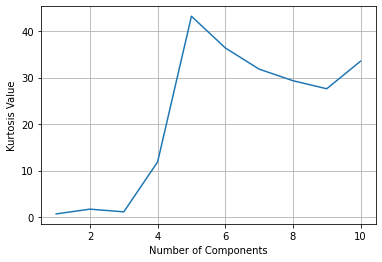

In [543]:
print('ICA: ')
print()
kurtosis_analysis(x)
#Z_2d = FastICA(n_components = 2).fit_transform(x)
##Plot_2d(Z_2d,y)

#Z_3d = FastICA(n_components = 3).fit_transform(x)
##Plot_3d(Z_3d,y)

#X_ica = FastICA(n_components = 5).fit_transform(x)


In [558]:
ica = FastICA(n_components=9)
x_ica = ica.fit_transform(x)
X_train_ica = ica.fit_transform(X_train_std)
X_test_ica = ica.fit_transform(X_test_std)
from sklearn.tree import DecisionTreeClassifier
dr = DecisionTreeClassifier(criterion='gini')
dr.fit(X_train_ica, y_train)
print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train_ica)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test_ica)))

dr.fit(X_train,y_train)

print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test)))


Training Data Overall Accuracy:  0.9382107137964105
Test Data Overall Accuracy:  0.28219878555449024
Training Data Overall Accuracy:  0.9382107137964105
Test Data Overall Accuracy:  0.382230744646852


Calculating Reconstruction Error


C:\Users\jwadhwa\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  # np.einsum allows having the lowest memory footprint.


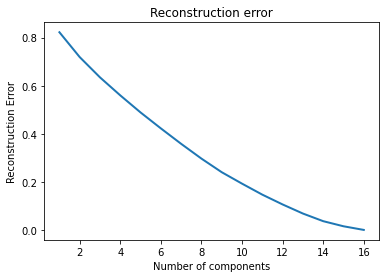

In [559]:
print("Calculating Reconstruction Error")

reconstruction_error = []
n_components = range(1, X_train_std.shape[1])
for comp in n_components:

	ica = FastICA(n_components = comp)
	X_transformed = ica.fit_transform(X_train)
	X_projected = ica.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

#	if(comp == gridSearch.best_estimator_.named_steps['ica'].n_components):
#		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error')
plt.show()

In [520]:
print(X_encoded)

       Gender  Ever_Married  Age  Graduated  Work_Experience  Spending_Score  \
0           0             0   22          0              1.0               0   
1           1             1   38          1              1.0               1   
2           1             1   67          1              1.0               0   
3           0             1   67          1              0.0               2   
4           1             1   40          1              1.0               2   
...       ...           ...  ...        ...              ...             ...   
10690       0             0   29          0              9.0               0   
10691       1             0   35          1              1.0               0   
10692       1             0   53          1              1.0               0   
10693       0             1   47          1              1.0               2   
10694       1             0   43          1              9.0               0   

       Family_Size  Var_1  Profession_A

Randomized Projections: 



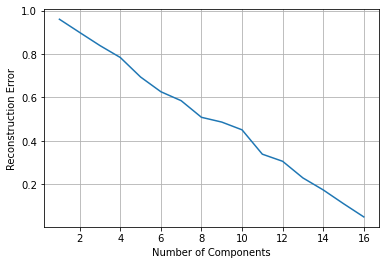

In [599]:
print('Randomized Projections: ')
print()
RP_analysis(x)
#Z_2d = GaussianRandomProjection(n_components = 2).fit_transform(x)
#Plot_2d(Z_2d,y)

#Z_3d = GaussianRandomProjection(n_components = 3).fit_transform(x)
#Plot_3d(Z_3d,y)

#best_X_rp = GaussianRandomProjection(n_components = 17).fit_transform(x)


In [600]:

rp = GaussianRandomProjection(n_components = 11)


# fit_transform() to calculate the coordinate system
x_rp = rp.fit_transform(x)
X_train_rp = rp.fit_transform(X_train_std)
# transform() to apply that coordinate system
X_test_rp = rp.transform(X_test_std)

Training Data Overall Accuracy:  0.9382107137964105
Test Data Overall Accuracy:  0.36305528922978586
Training Data Overall Accuracy:  0.9382107137964105
Test Data Overall Accuracy:  0.3908596995845318


[]

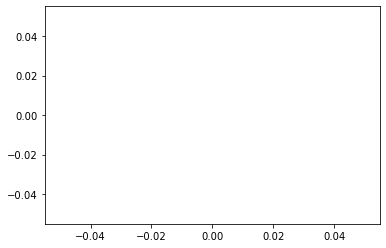

In [601]:

from sklearn.tree import DecisionTreeClassifier
dr = DecisionTreeClassifier(criterion='gini')
dr.fit(X_train_rp, y_train)

print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train_rp)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test_rp)))
plt.plot()

dr.fit(X_train,y_train)

print("Training Data Overall Accuracy: ",
accuracy_score(y_train, dr.predict(X_train)))

print("Test Data Overall Accuracy: ",
accuracy_score(y_test, dr.predict(X_test)))
plt.plot()


In [612]:
print('Truncated SVD:')
print()

tsvd = TruncatedSVD(n_components = 17)
#tsvd.fit(x)
TSVD_Analysis(tsvd)
#best_n = 7

#Z_2d = TruncatedSVD(n_components = 2).fit_transform(x)
#Plot_2d(Z_2d,y)

#Z_3d = TruncatedSVD(n_components = 3).fit_transform(x)
#Plot_3d(Z_3d,y)

#best_X_tsvd = TruncatedSVD(n_components = best_n).fit_transform(x)



Truncated SVD:



AttributeError: 'TruncatedSVD' object has no attribute 'explained_variance_ratio_'

<Figure size 432x288 with 0 Axes>